In [4]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
!pip install gensim
!pip install optuna

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
import string
import inflect
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from string import digits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import gensim
import gensim.corpora as corpora
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from gensim.utils import simple_preprocess
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
import optuna


# Data Preprocessing

### Understanding Problem Statement

---

Our dataset comprises 1700 unique articles and it's title sourced from various outlets. Each article is accompanied by a label indicating its topic, such as sports, science, politics, and more. This label serves as the target variable for classification based on the content of the articles.


In [6]:
df = pd.read_csv("data.csv")

In [7]:
df

title  \
0     Oscar Pistorius, Paralympian convicted of murd...   
1     Aliens, killer asteroids and Mars: Lawmakers a...   
2     The 2024 Super Bowl becomes the most watched N...   
3     EVs won over early adopters, but mainstream bu...   
4     MLB commissioner Rob Manfred says he will reti...   
...                                                 ...   
1740  California wildfires created toxic chromium, r...   
1741  Iowa's Caitlin Clark becomes all-time NCAA wom...   
1742  They opened a Haitian food truck, then were to...   
1743  Ex-coach sues Northwestern for $130M for wrong...   
1744  Lessons from sleeplessness: The 60th anniversa...   

                                                content  category  \
0     Enlarge this image Paralympian athlete Oscar P...    sports   
1     Two lawmakers on Wednesday announced a newly r...   science   
2     Enlarge this image A San Francisco 49ers fan r...    sports   
3     Enlarge this image Electric F-150 Lightning pi...  business   
4     TAMPA, Fla. — Baseball Commissioner Rob Manfre...    sports   
...                                                 ...       ...   
1740  After some recent intense wildfires in Norther...   science   
1741  Iowa Hawkeyes guard Caitlin Clark has been mak...    sports   
1742  A married couple who fled Haiti for Virginia a...  business   
1743  Enlarge this image Then-Northwestern head coac...    sports   
1744  Enlarge this image In January 1964, American s...   science   

                                                   link  
0     https://www.npr.org/2023/11/24/1215084865/osca...  
1     https://www.nbcnews.com/science/space/lawmaker...  
2     https://www.npr.org/2024/02/13/1231058556/most...  
3     https://www.npr.org/2024/02/07/1227707306/ev-e...  
4     https://www.nbcnews.com/news/sports/mlb-commis...  
...                                                 ...  
1740  https://www.nbcnews.com/science/environment/ca...  
1741  https://www.nbcnews.com/news/sports/caitlin-cl...  
1742  https://www.nbcnews.com/news/nbcblk/haitian-fo...  
1743  https://www.npr.org/2023/10/05/1203949028/nort...  
1744  https://www.npr.org/2024/01/28/1227217274/slee...  

[1745 rows x 4 columns]

In [8]:
df.content[0]

'Enlarge this image Paralympian athlete Oscar Pistorius, accused of the murder of his girlfriend Reeva Steenkamp, arriving at a court in Pretoria, South Africa, for a hearing in July 2016. The athlete will be released for parole in January. Pool/Getty Images hide caption toggle caption Pool/Getty Images Paralympian athlete Oscar Pistorius, accused of the murder of his girlfriend Reeva Steenkamp, arriving at a court in Pretoria, South Africa, for a hearing in July 2016. The athlete will be released for parole in January. Pool/Getty Images Oscar Pistorius, a South African Paralympian, is set to be released from jail on parole nearly 11 years after fatally shooting his girlfriend, Reeva Steenkamp. A parole board found Friday that Pistorius, 37, had completed the minimum detention requirement — half of his 13-year sentence — to make him parole-eligible under South African law. His release date is set for Jan. 5, 2024. A double-amputee since infancy, Pistorius was once one of the world\'s m

We can observe lots of noise at first mail like extra spaces, many hyphen marks, different cases, and many more.

### Missing Value

In [9]:
df.drop_duplicates(inplace=True)
# Remove "Enlarge this image" from the content column
df['content'] = df['content'].str.replace('Enlarge this image', '')
df['content'] = df['content'].str.replace('hide caption', '')
df['content'] = df['content'].str.replace('toggle caption', '')
df['content'] = df['content'].str.replace('caption toggle', '')

In [10]:
df.isna().sum()

title       54
content     31
category     0
link         0
dtype: int64

In [11]:
df[df.title.isna() == True]

title                                            content  category  \
27     NaN                                                NaN  politics   
36     NaN  Everything you need to know about Super Bowl 5...    sports   
52     NaN                                                NaN  politics   
99     NaN                                                NaN  politics   
100    NaN                                                NaN    sports   
158    NaN                                                NaN   science   
202    NaN                                                NaN    health   
210    NaN                                                NaN  politics   
245    NaN                                                NaN  politics   
294    NaN                                                NaN    sports   
312    NaN                                             bnody    science   
340    NaN  Another industrial slaughterhouse cleaner has ...  business   
346    NaN                                                NaN  politics   
357    NaN                                                NaN  politics   
382    NaN  WASHINGTON — Former President Barack Obama has...  politics   
442    NaN  Christian McCaffrey scored two touchdowns and ...    sports   
521    NaN                                                NaN  politics   
527    NaN  Here's the latest from the 2024 campaign trail...  politics   
582    NaN                                                NaN  politics   
656    NaN  A U.S. senator from Oregon introduced a bill T...  politics   
730    NaN  Veteran Wall Street executive Omeed Malik plan...  business   
763    NaN  Here's the latest from Super Tuesday:Super Tue...  politics   
785    NaN                                                NaN    sports   
794    NaN                                                NaN   science   
805    NaN                                                NaN  business   
813    NaN  Olympic gold medal gymnast Mary Lou Retton fac...    health   
852    NaN                                                NaN  politics   
878    NaN  A first-of-its kind fundraiser featuring three...  politics   
897    NaN  Gabby Douglas, who was the first Black gymnast...    sports   
935    NaN                                                NaN  business   
940    NaN                                                NaN  politics   
973    NaN                                                NaN    health   
974    NaN  One person is dead and at least 20 others were...    sports   
986    NaN  The water cycle that shuttles Earth’s most vit...   science   
989    NaN                                                NaN  politics   
1008   NaN                                                NaN  politics   
1013   NaN                                                NaN  politics   
1074   NaN                                                NaN    sports   
1145   NaN  Federal financial regulators are exploring all...  business   
1157   NaN                                                NaN  politics   
1172   NaN  The federal agency charged with safeguarding t...  politics   
1237   NaN                                                NaN  politics   
1243   NaN  Highlights from the State of the Union address...  politics   
1267   NaN  It was a mostly successful second outing for S...   science   
1272   NaN                                                NaN  politics   
1276   NaN                                                NaN  politics   
1373   NaN                                                NaN    sports   
1417   NaN                                                NaN    health   
1456   NaN                                                NaN  politics   
1586   NaN  What to know about today's landingThe “Odysseu...   science   
1637   NaN  The head of the NAACP is calling on Black stud...  politics   
1689   NaN  WASHINGTON — Before Vice President Kamala Harr...  politics   
1700   NaN  Moments after he l

In [12]:
df = df.dropna()
df

title  \
0     Oscar Pistorius, Paralympian convicted of murd...   
1     Aliens, killer asteroids and Mars: Lawmakers a...   
2     The 2024 Super Bowl becomes the most watched N...   
3     EVs won over early adopters, but mainstream bu...   
4     MLB commissioner Rob Manfred says he will reti...   
...                                                 ...   
1740  California wildfires created toxic chromium, r...   
1741  Iowa's Caitlin Clark becomes all-time NCAA wom...   
1742  They opened a Haitian food truck, then were to...   
1743  Ex-coach sues Northwestern for $130M for wrong...   
1744  Lessons from sleeplessness: The 60th anniversa...   

                                                content  category  \
0      Paralympian athlete Oscar Pistorius, accused ...    sports   
1     Two lawmakers on Wednesday announced a newly r...   science   
2      A San Francisco 49ers fan reacts while watchi...    sports   
3      Electric F-150 Lightning pickup trucks travel...  business   
4     TAMPA, Fla. — Baseball Commissioner Rob Manfre...    sports   
...                                                 ...       ...   
1740  After some recent intense wildfires in Norther...   science   
1741  Iowa Hawkeyes guard Caitlin Clark has been mak...    sports   
1742  A married couple who fled Haiti for Virginia a...  business   
1743   Then-Northwestern head coach Pat Fitzgerald s...    sports   
1744   In January 1964, American student Randy Gardn...   science   

                                                   link  
0     https://www.npr.org/2023/11/24/1215084865/osca...  
1     https://www.nbcnews.com/science/space/lawmaker...  
2     https://www.npr.org/2024/02/13/1231058556/most...  
3     https://www.npr.org/2024/02/07/1227707306/ev-e...  
4     https://www.nbcnews.com/news/sports/mlb-commis...  
...                                                 ...  
1740  https://www.nbcnews.com/science/environment/ca...  
1741  https://www.nbcnews.com/news/sports/caitlin-cl...  
1742  https://www.nbcnews.com/news/nbcblk/haitian-fo...  
1743  https://www.npr.org/2023/10/05/1203949028/nort...  
1744  https://www.npr.org/2024/01/28/1227217274/slee...  

[1691 rows x 4 columns]

In [13]:
df.isnull().sum()

title       0
content     0
category    0
link        0
dtype: int64

In [14]:
df = pd.DataFrame(df)

### Remove URL

In [15]:
import re
def remove_url(data):
    url_removed = []
    for line in data:
        url_removed.append(re.sub('http[s]?://\S+', '', line))
    return url_removed

df = df.apply(remove_url)

In [16]:
df.drop("link", axis=1, inplace=True)


In [17]:
df

title  \
0     Oscar Pistorius, Paralympian convicted of murd...   
1     Aliens, killer asteroids and Mars: Lawmakers a...   
2     The 2024 Super Bowl becomes the most watched N...   
3     EVs won over early adopters, but mainstream bu...   
4     MLB commissioner Rob Manfred says he will reti...   
...                                                 ...   
1740  California wildfires created toxic chromium, r...   
1741  Iowa's Caitlin Clark becomes all-time NCAA wom...   
1742  They opened a Haitian food truck, then were to...   
1743  Ex-coach sues Northwestern for $130M for wrong...   
1744  Lessons from sleeplessness: The 60th anniversa...   

                                                content  category  
0      Paralympian athlete Oscar Pistorius, accused ...    sports  
1     Two lawmakers on Wednesday announced a newly r...   science  
2      A San Francisco 49ers fan reacts while watchi...    sports  
3      Electric F-150 Lightning pickup trucks travel...  business  
4     TAMPA, Fla. — Baseball Commissioner Rob Manfre...    sports  
...                                                 ...       ...  
1740  After some recent intense wildfires in Norther...   science  
1741  Iowa Hawkeyes guard Caitlin Clark has been mak...    sports  
1742  A married couple who fled Haiti for Virginia a...  business  
1743   Then-Northwestern head coach Pat Fitzgerald s...    sports  
1744   In January 1964, American student Randy Gardn...   science  

[1691 rows x 3 columns]

In [18]:
df.content[1]

'Two lawmakers on Wednesday announced a newly relaunched group in Congress that will focus on issues related to planetary science and space exploration.The bipartisan Planetary Science Caucus is being led by Rep. Judy Chu, D-Calif., and Rep.\xa0Don Bacon, R-Neb. The group aims to advance policies and promote federal investment in space science, which the caucus said is “critical to our economy, national security, and American leadership in science and technology.”The Planetary Science Caucus, which was initially formed in 2018 but was later abandoned in 2021, listed several key goals:Support government agencies, commercial partners, academic institutions and nonprofits in the research and exploration of spaceBolster efforts by space organizations to find, track, characterize and mitigate the threat of potentially hazardous near-Earth objectsFacilitate the search for life in our solar system and beyond, answering the fundamental question: Are we alone in the universe?Raise awareness of 

### Remove hashtag

In [19]:
def remove_hashtag(data):
    hashtag_removed = []
    translator = str.maketrans('#', ' '*len('#'), '')
    for line in data:
        hashtag_removed.append(line.translate(translator))
    return hashtag_removed

df = df.apply(remove_hashtag)


### Expand Contractions

Contraction is the shortened form of a word like don’t stands for do not, aren’t stands for are not

In [20]:
contractions_dict = {"ain't": "are not","'s":" is","aren't": "are not", "n't" : "not"}
# Regular expression for finding contractions
# "'d" :"had or would"
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)
# Expanding Contractions in the reviews
df['content']=df['content'].apply(lambda x:expand_contractions(x))
df['title']=df['title'].apply(lambda x:expand_contractions(x))

In [21]:
df.content[0]

' Paralympian athlete Oscar Pistorius, accused of the murder of his girlfriend Reeva Steenkamp, arriving at a court in Pretoria, South Africa, for a hearing in July 2016. The athlete will be released for parole in January. Pool/Getty Images   Pool/Getty Images Paralympian athlete Oscar Pistorius, accused of the murder of his girlfriend Reeva Steenkamp, arriving at a court in Pretoria, South Africa, for a hearing in July 2016. The athlete will be released for parole in January. Pool/Getty Images Oscar Pistorius, a South African Paralympian, is set to be released from jail on parole nearly 11 years after fatally shooting his girlfriend, Reeva Steenkamp. A parole board found Friday that Pistorius, 37, had completed the minimum detention requirement — half of his 13-year sentence — to make him parole-eligible under South African law. His release date is set for Jan. 5, 2024. A double-amputee since infancy, Pistorius was once one of the world is most admired runners, known as the "Blade Run

Lower case

In [22]:
df['title'] = df['title'].str.lower()
df['content'] = df['content'].str.lower()

In [23]:
df

title  \
0     oscar pistorius, paralympian convicted of murd...   
1     aliens, killer asteroids and mars: lawmakers a...   
2     the 2024 super bowl becomes the most watched n...   
3     evs won over early adopters, but mainstream bu...   
4     mlb commissioner rob manfred says he will reti...   
...                                                 ...   
1740  california wildfires created toxic chromium, r...   
1741  iowa is caitlin clark becomes all-time ncaa wo...   
1742  they opened a haitian food truck, then were to...   
1743  ex-coach sues northwestern for $130m for wrong...   
1744  lessons from sleeplessness: the 60th anniversa...   

                                                content  category  
0      paralympian athlete oscar pistorius, accused ...    sports  
1     two lawmakers on wednesday announced a newly r...   science  
2      a san francisco 49ers fan reacts while watchi...    sports  
3      electric f-150 lightning pickup trucks travel...  business  
4     tampa, fla. — baseball commissioner rob manfre...    sports  
...                                                 ...       ...  
1740  after some recent intense wildfires in norther...   science  
1741  iowa hawkeyes guard caitlin clark has been mak...    sports  
1742  a married couple who fled haiti for virginia a...  business  
1743   then-northwestern head coach pat fitzgerald s...    sports  
1744   in january 1964, american student randy gardn...   science  

[1691 rows x 3 columns]

### Remove punctuation

In [24]:
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df["title"]= df["title"].apply(lambda text: remove_punctuation(text))
df["content"]= df["content"].apply(lambda text: remove_punctuation(text))
df.head()

title  \
0  oscar pistorius paralympian convicted of murde...   
1  aliens killer asteroids and mars lawmakers ann...   
2  the 2024 super bowl becomes the most watched n...   
3  evs won over early adopters but mainstream buy...   
4  mlb commissioner rob manfred says he will reti...   

                                             content  category  
0   paralympian athlete oscar pistorius accused o...    sports  
1  two lawmakers on wednesday announced a newly r...   science  
2   a san francisco 49ers fan reacts while watchi...    sports  
3   electric f150 lightning pickup trucks travel ...  business  
4  tampa fla — baseball commissioner rob manfred ...    sports

In [25]:
df["title"] = df["title"].apply(lambda x: re.sub(r"[–”“—’‘]", "", x))
df["content"] = df["content"].apply(lambda x: re.sub(r"[–”“—’‘]", "", x))

In [26]:
df["content"][0]

' paralympian athlete oscar pistorius accused of the murder of his girlfriend reeva steenkamp arriving at a court in pretoria south africa for a hearing in july 2016 the athlete will be released for parole in january poolgetty images   poolgetty images paralympian athlete oscar pistorius accused of the murder of his girlfriend reeva steenkamp arriving at a court in pretoria south africa for a hearing in july 2016 the athlete will be released for parole in january poolgetty images oscar pistorius a south african paralympian is set to be released from jail on parole nearly 11 years after fatally shooting his girlfriend reeva steenkamp a parole board found friday that pistorius 37 had completed the minimum detention requirement  half of his 13year sentence  to make him paroleeligible under south african law his release date is set for jan 5 2024 a doubleamputee since infancy pistorius was once one of the world is most admired runners known as the blade runner for the carbonfiber prostheti

### Tokenization

In [27]:
def tokenize_sentence(data):
  tokenized_docs = []

  for line in data:
    tokenized_docs.append(word_tokenize(line))

  return tokenized_docs

df = df.apply(tokenize_sentence)

In [28]:
df.content

0       [paralympian, athlete, oscar, pistorius, accus...
1       [two, lawmakers, on, wednesday, announced, a, ...
2       [a, san, francisco, 49ers, fan, reacts, while,...
3       [electric, f150, lightning, pickup, trucks, tr...
4       [tampa, fla, baseball, commissioner, rob, manf...
                              ...                        
1740    [after, some, recent, intense, wildfires, in, ...
1741    [iowa, hawkeyes, guard, caitlin, clark, has, b...
1742    [a, married, couple, who, fled, haiti, for, vi...
1743    [thennorthwestern, head, coach, pat, fitzgeral...
1744    [in, january, 1964, american, student, randy, ...
Name: content, Length: 1691, dtype: object

### Remove words and digits containing digits

In [29]:
def remove_digits(data):
    digit_removed = []

    for doc in data:
        temp = []
        for word in doc:
            # Check if the word contains only digits
            if not word.isdigit():
                temp.append(word)
        digit_removed.append(temp)

    return digit_removed

df = df.apply(remove_digits)

In [30]:
df.content[0]

['paralympian',
 'athlete',
 'oscar',
 'pistorius',
 'accused',
 'of',
 'the',
 'murder',
 'of',
 'his',
 'girlfriend',
 'reeva',
 'steenkamp',
 'arriving',
 'at',
 'a',
 'court',
 'in',
 'pretoria',
 'south',
 'africa',
 'for',
 'a',
 'hearing',
 'in',
 'july',
 'the',
 'athlete',
 'will',
 'be',
 'released',
 'for',
 'parole',
 'in',
 'january',
 'poolgetty',
 'images',
 'poolgetty',
 'images',
 'paralympian',
 'athlete',
 'oscar',
 'pistorius',
 'accused',
 'of',
 'the',
 'murder',
 'of',
 'his',
 'girlfriend',
 'reeva',
 'steenkamp',
 'arriving',
 'at',
 'a',
 'court',
 'in',
 'pretoria',
 'south',
 'africa',
 'for',
 'a',
 'hearing',
 'in',
 'july',
 'the',
 'athlete',
 'will',
 'be',
 'released',
 'for',
 'parole',
 'in',
 'january',
 'poolgetty',
 'images',
 'oscar',
 'pistorius',
 'a',
 'south',
 'african',
 'paralympian',
 'is',
 'set',
 'to',
 'be',
 'released',
 'from',
 'jail',
 'on',
 'parole',
 'nearly',
 'years',
 'after',
 'fatally',
 'shooting',
 'his',
 'girlfriend',


### Remove stopwords

In [31]:
def remove_stopwords(data):

  stopword_removed = []

  stop_words = set(stopwords.words('english'))
  more_stop = ["say", "said", "says", "u"]
  for word in more_stop:
    stop_words.add(word)

  for doc in data:
    temp = []
    for word in doc:
      if word not in stop_words:
        temp.append(word)

    stopword_removed.append(temp)

  return stopword_removed

df = df.apply(remove_stopwords)

In [32]:
df.content[0]

['paralympian',
 'athlete',
 'oscar',
 'pistorius',
 'accused',
 'murder',
 'girlfriend',
 'reeva',
 'steenkamp',
 'arriving',
 'court',
 'pretoria',
 'south',
 'africa',
 'hearing',
 'july',
 'athlete',
 'released',
 'parole',
 'january',
 'poolgetty',
 'images',
 'poolgetty',
 'images',
 'paralympian',
 'athlete',
 'oscar',
 'pistorius',
 'accused',
 'murder',
 'girlfriend',
 'reeva',
 'steenkamp',
 'arriving',
 'court',
 'pretoria',
 'south',
 'africa',
 'hearing',
 'july',
 'athlete',
 'released',
 'parole',
 'january',
 'poolgetty',
 'images',
 'oscar',
 'pistorius',
 'south',
 'african',
 'paralympian',
 'set',
 'released',
 'jail',
 'parole',
 'nearly',
 'years',
 'fatally',
 'shooting',
 'girlfriend',
 'reeva',
 'steenkamp',
 'parole',
 'board',
 'found',
 'friday',
 'pistorius',
 'completed',
 'minimum',
 'detention',
 'requirement',
 'half',
 '13year',
 'sentence',
 'make',
 'paroleeligible',
 'south',
 'african',
 'law',
 'release',
 'date',
 'set',
 'jan',
 'doubleamputee',

In [33]:
dt = df.copy()

### Stemming and Lemmatization

Stemming is a process to reduce the word to its root stem for example run, running, runs, runed derived from the same word as run. basically stemming do is remove the prefix or suffix from word like ing, s, es, etc...

Lemmatization is similar to stemming, used to stem the words into root word but differs in working. Actually, Lemmatization is a systematic way to reduce the words into their lemma by matching them with a language dictionary.

In [34]:
from nltk.stem import WordNetLemmatizer
def apply_stemmer(data):
  stemmed_docs = []

  stemmer = PorterStemmer()

  for doc in data:
    stemmed_docs.append([stemmer.stem(plural) for plural in doc])

  return stemmed_docs

df = df.apply(apply_stemmer)
def lemmatize_words(data):
    lemmatized_docs = []
    lemmatizer = WordNetLemmatizer()
    for doc in data:
        lemmatized_docs.append([lemmatizer.lemmatize(word) for word in doc])
    return lemmatized_docs
df = df.apply(lemmatize_words)


In [35]:
df.content[3]

['electr',
 'f150',
 'lightn',
 'pickup',
 'truck',
 'travel',
 'product',
 'line',
 'ford',
 'roug',
 'electr',
 'vehicl',
 'center',
 'dearborn',
 'michigan',
 'septemb',
 'ford',
 'cut',
 'two',
 'shift',
 'plant',
 'reduc',
 'product',
 'lightn',
 'week',
 'ford',
 'ceo',
 'jim',
 'farley',
 'told',
 'investor',
 'journey',
 'ev',
 'inevit',
 'eye',
 'jeff',
 'kowalskyafp',
 'via',
 'getti',
 'imag',
 'jeff',
 'kowalskyafp',
 'via',
 'getti',
 'imag',
 'electr',
 'f150',
 'lightn',
 'pickup',
 'truck',
 'travel',
 'product',
 'line',
 'ford',
 'roug',
 'electr',
 'vehicl',
 'center',
 'dearborn',
 'michigan',
 'septemb',
 'ford',
 'cut',
 'two',
 'shift',
 'plant',
 'reduc',
 'product',
 'lightn',
 'week',
 'ford',
 'ceo',
 'jim',
 'farley',
 'told',
 'investor',
 'journey',
 'ev',
 'inevit',
 'eye',
 'jeff',
 'kowalskyafp',
 'via',
 'getti',
 'imag',
 'bad',
 'headlin',
 'electr',
 'vehicl',
 'pile',
 'late',
 'sale',
 'level',
 'around',
 'new',
 'car',
 'market',
 'even',
 'dip'

# Visualization


In [36]:
dt['title'] = dt['title'].apply(lambda x:' '.join(map(str,x)))
dt['content'] = dt['content'].apply(lambda x:' '.join(map(str,x)))
dt['category'] = dt['category'].apply(lambda x:''.join(map(str,x)))
dt

title  \
0     oscar pistorius paralympian convicted murder r...   
1     aliens killer asteroids mars lawmakers announc...   
2     super bowl becomes watched nfl championship hi...   
3     evs early adopters mainstream buyers along rid...   
4           mlb commissioner rob manfred retire january   
...                                                 ...   
1740  california wildfires created toxic chromium re...   
1741  iowa caitlin clark becomes alltime ncaa women ...   
1742  opened haitian food truck told go back country...   
1743  excoach sues northwestern 130m wrongful termin...   
1744  lessons sleeplessness 60th anniversary randy g...   

                                                content  category  
0     paralympian athlete oscar pistorius accused mu...    sports  
1     two lawmakers wednesday announced newly relaun...   science  
2     san francisco 49ers fan reacts watching teleca...    sports  
3     electric f150 lightning pickup trucks travel p...  business  
4     tampa fla baseball commissioner rob manfred th...    sports  
...                                                 ...       ...  
1740  recent intense wildfires northern california s...   science  
1741  iowa hawkeyes guard caitlin clark making lots ...    sports  
1742  married couple fled haiti virginia achieved am...  business  
1743  thennorthwestern head coach pat fitzgerald sta...    sports  
1744  january american student randy gardner sits be...   science  

[1691 rows x 3 columns]

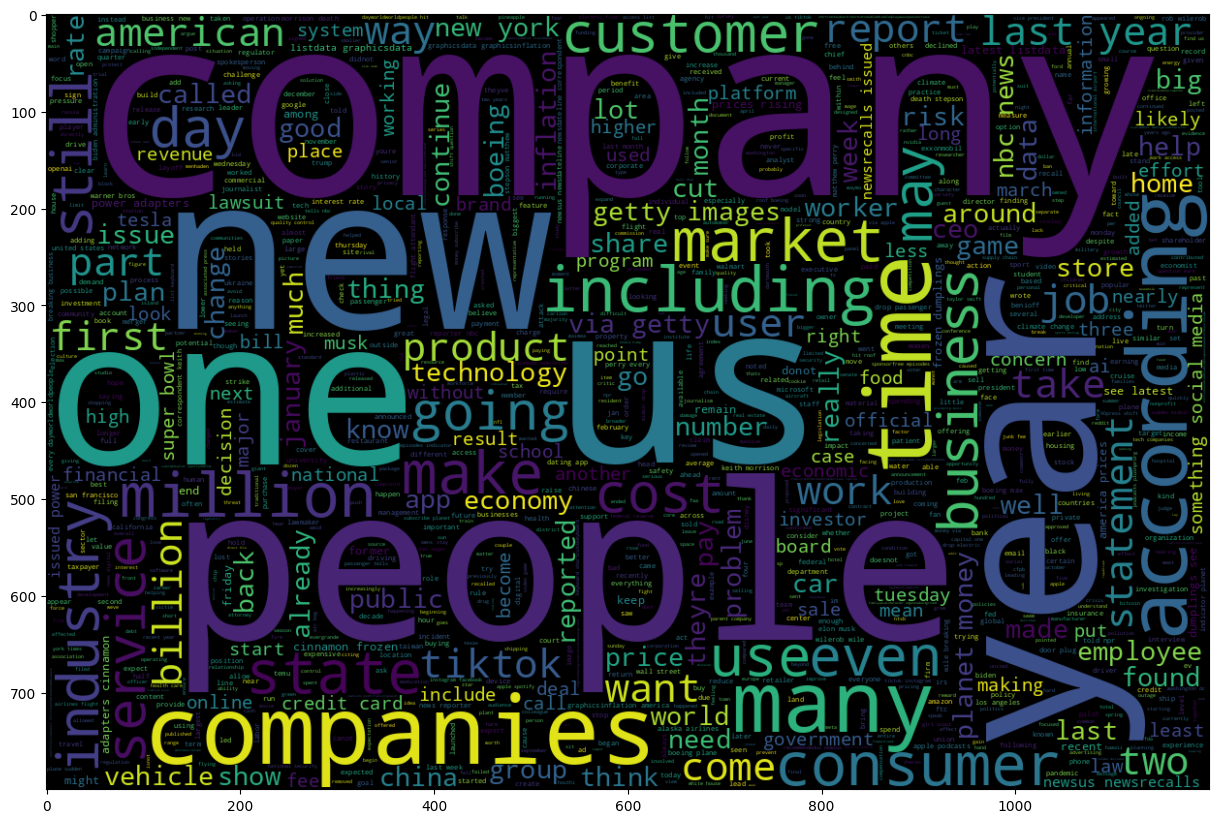

In [37]:
business = dt.title[dt['category']=="business"] + " " + dt.content[dt['category']=="business"]
plt.figure(figsize = (15,20))
wordcloud = WordCloud(min_font_size = 3,  max_words = 2000 , width = 1200 , height = 800).generate(" ".join(business))
plt.imshow(wordcloud,interpolation = 'bilinear')

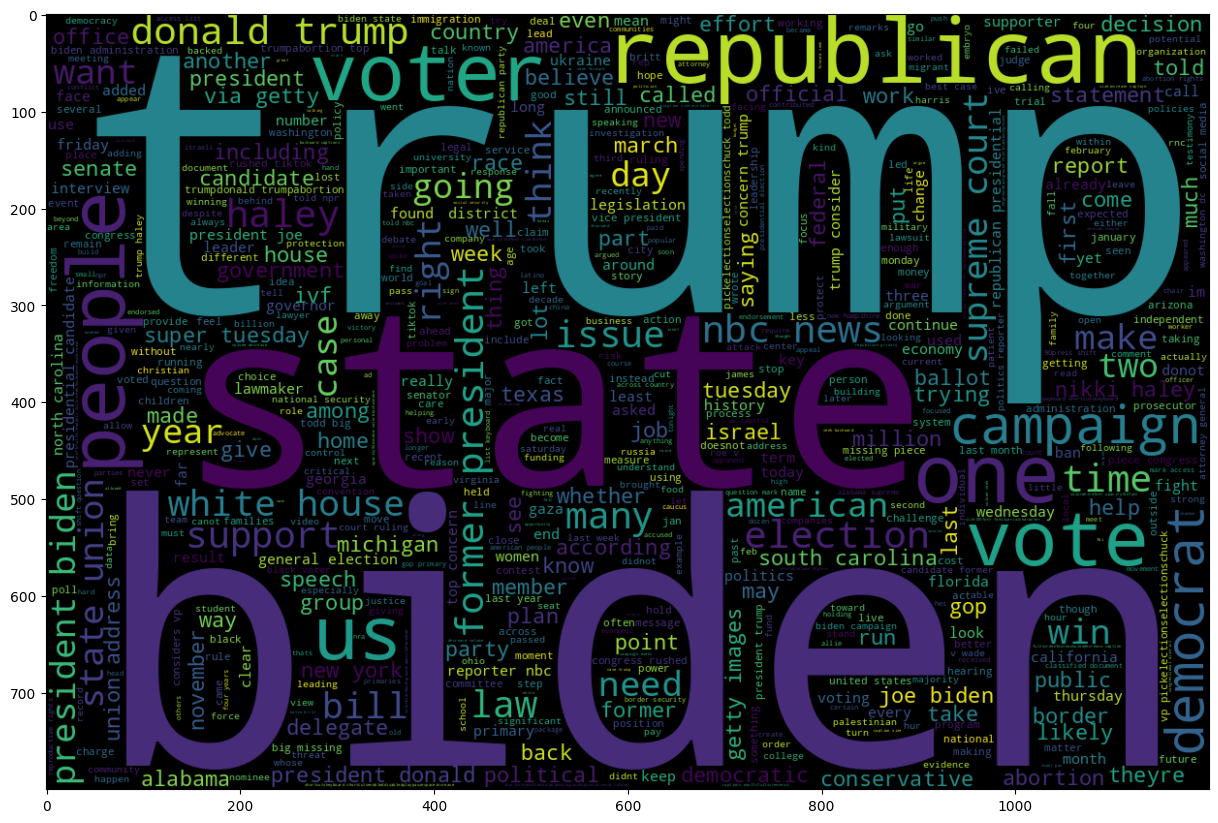

In [38]:
politics = dt.title[dt['category']=="politics"] + " " + dt.content[dt['category']=="politics"]
plt.figure(figsize = (15,20))
wordcloud = WordCloud(min_font_size = 3,  max_words = 2000 , width = 1200 , height = 800).generate(" ".join(politics))
plt.imshow(wordcloud,interpolation = 'bilinear')

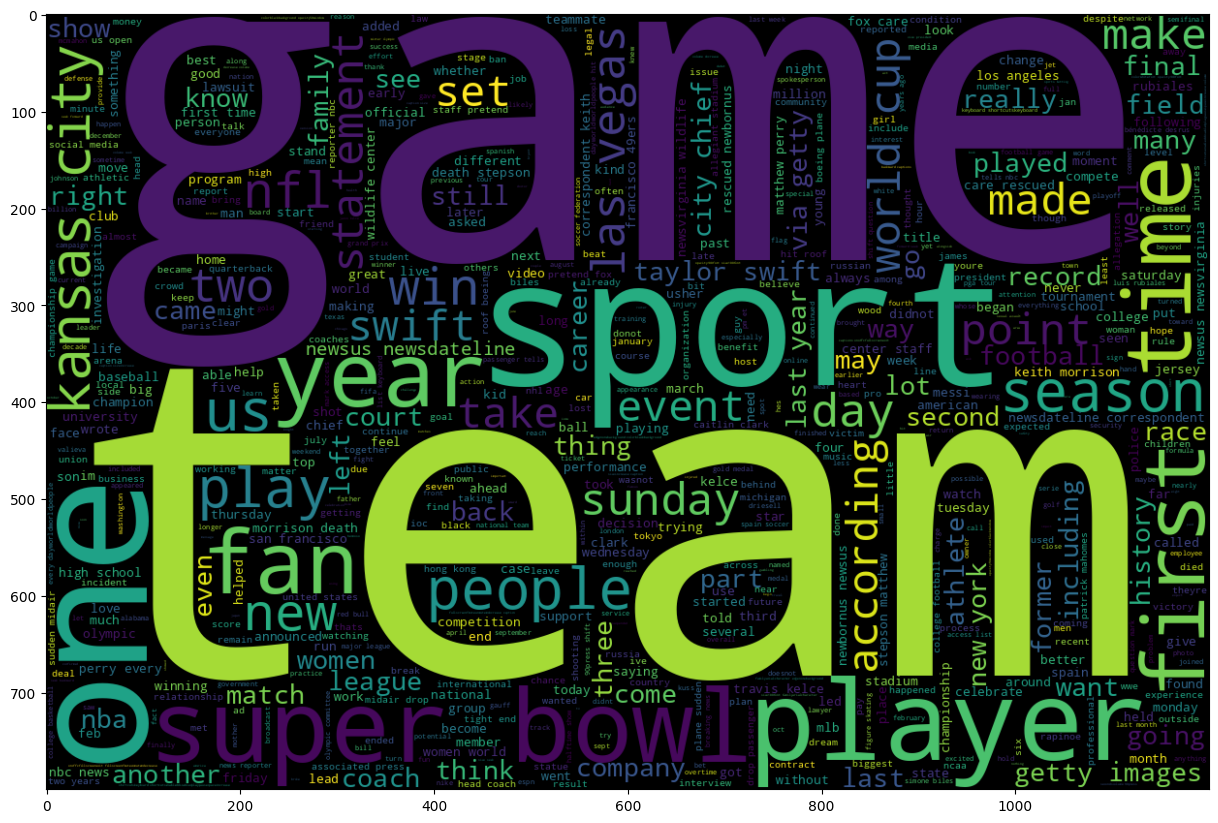

In [39]:
sports = dt.title[dt['category']=="sports"] + " " + dt.content[dt['category']=="sports"]
plt.figure(figsize = (15,20))
wordcloud = WordCloud(min_font_size = 3,  max_words = 2000 , width = 1200 , height = 800).generate(" ".join(sports))
plt.imshow(wordcloud,interpolation = 'bilinear')

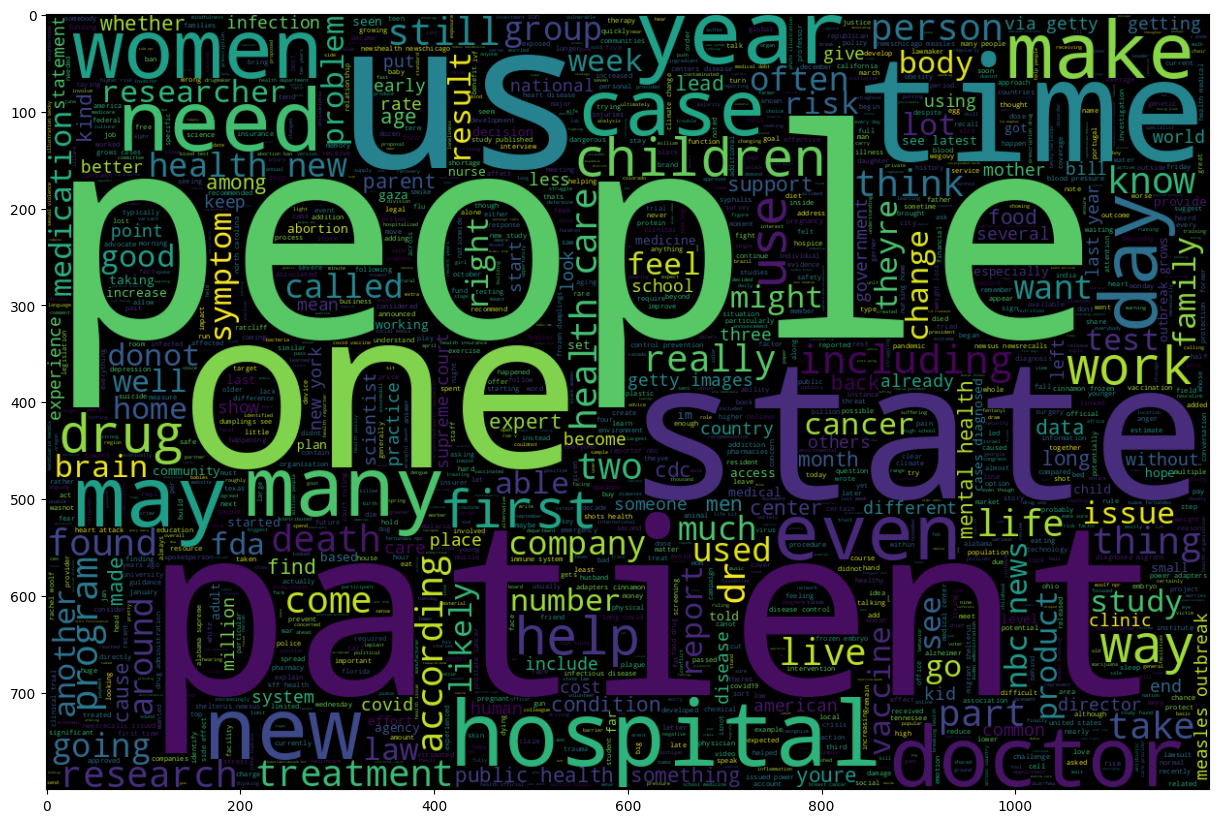

In [40]:
health = dt.title[dt['category']=="health"] + " " + dt.content[dt['category']=="health"]
plt.figure(figsize = (15,20))
wordcloud = WordCloud(min_font_size = 3,  max_words = 2000 , width = 1200 , height = 800).generate(" ".join(health))
plt.imshow(wordcloud,interpolation = 'bilinear')

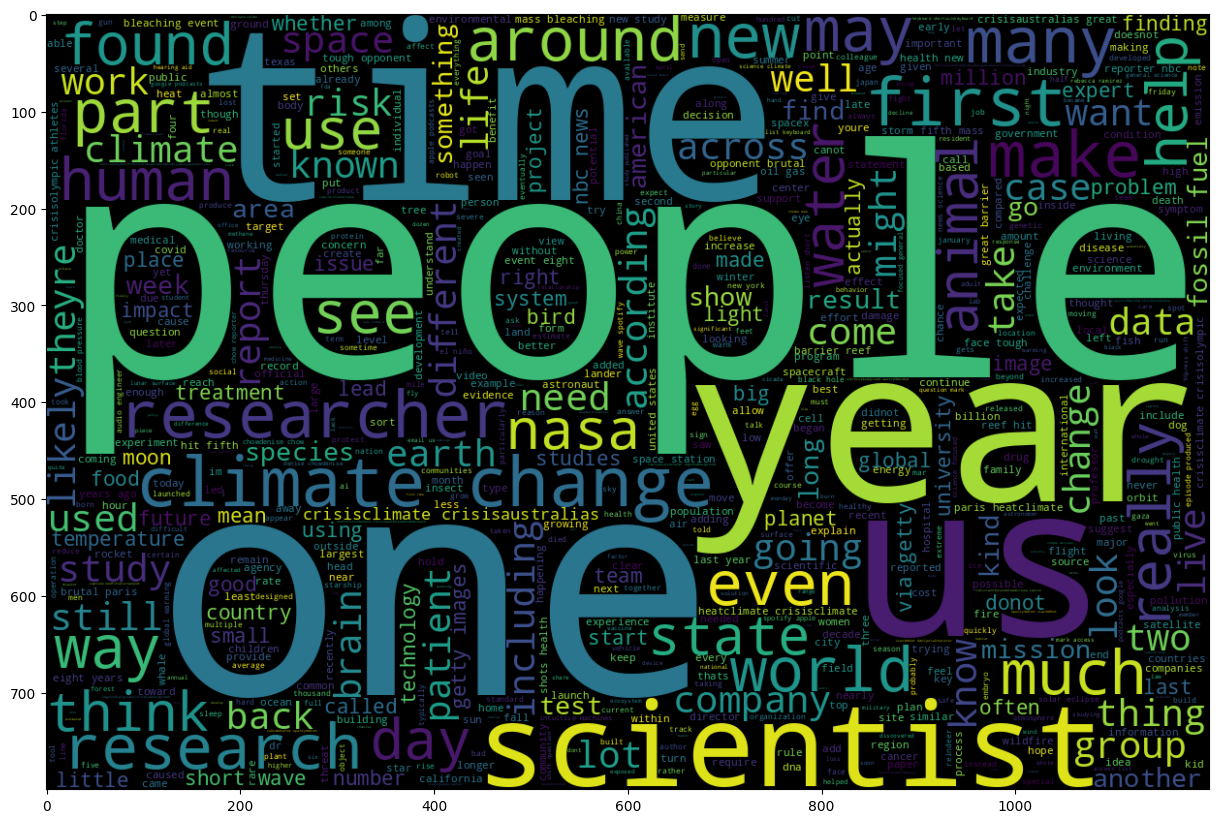

In [41]:
science = dt.title[dt['category']=="science"] + " " + dt.content[dt['category']=="science"]
plt.figure(figsize = (15,20))
wordcloud = WordCloud(min_font_size = 3,  max_words = 2000 , width = 1200 , height = 800).generate(" ".join(science))
plt.imshow(wordcloud,interpolation = 'bilinear')

# Feature Extraction

### Frequency Base Embedding

##### Bag of words

Bag of words approach involves breaking down a piece of text into individual words, and then representing the text as a frequency distribution of those words. In other words, we’re creating a “bag” of all the words in the text, without any regard for their order or context, and then counting how many times each word appears in that bag. This simple yet effective method allows us to extract meaningful insights from large volumes of text data, such as identifying the most frequent words, analyzing sentiment, or even predicting future trends.

In [42]:
combined_paragraphs = []
# create a full paragraph of new
for index, row in df.iterrows():
    title_text = ' '.join(row['title'])
    content_text = ' '.join(row['content'])
    combined_text = title_text + ' ' + content_text
    combined_paragraphs.append(combined_text)

print(combined_paragraphs[1])

alien killer asteroid mar lawmak announc caucu focus space planetari scienc two lawmak wednesday announc newli relaunch group congress focu issu relat planetari scienc space explorationth bipartisan planetari scienc caucu led rep judi chu dcalif rep bacon rneb group aim advanc polici promot feder invest space scienc caucu critic economi nation secur american leadership scienc technologyth planetari scienc caucu initi form later abandon list sever key goalssupport govern agenc commerci partner academ institut nonprofit research explor spacebolst effort space organ find track character mitig threat potenti hazard nearearth objectsfacilit search life solar system beyond answer fundament question alon universerais awar econom benefit feder invest space scienc technolog develop stem educationfor millennium human observ cosmo incorpor bounti lesson earth im ecstat continu proud tradit hall congress work rep bacon launch planetari scienc caucu chu statementth lawmak hand full sever major nasa

In [43]:
df['paragraph'] = combined_paragraphs
df

title  \
0     [oscar, pistoriu, paralympian, convict, murder...   
1     [alien, killer, asteroid, mar, lawmak, announc...   
2     [super, bowl, becom, watch, nfl, championship,...   
3     [ev, earli, adopt, mainstream, buyer, along, r...   
4         [mlb, commission, rob, manfr, retir, januari]   
...                                                 ...   
1740  [california, wildfir, creat, toxic, chromium, ...   
1741  [iowa, caitlin, clark, becom, alltim, ncaa, wo...   
1742  [open, haitian, food, truck, told, go, back, c...   
1743  [excoach, sue, northwestern, 130m, wrong, term...   
1744  [lesson, sleepless, 60th, anniversari, randi, ...   

                                                content  category  \
0     [paralympian, athlet, oscar, pistoriu, accus, ...   [sport]   
1     [two, lawmak, wednesday, announc, newli, relau...  [scienc]   
2     [san, francisco, 49er, fan, react, watch, tele...   [sport]   
3     [electr, f150, lightn, pickup, truck, travel, ...    [busi]   
4     [tampa, fla, basebal, commission, rob, manfr, ...   [sport]   
...                                                 ...       ...   
1740  [recent, intens, wildfir, northern, california...  [scienc]   
1741  [iowa, hawkey, guard, caitlin, clark, make, lo...   [sport]   
1742  [marri, coupl, fled, haiti, virginia, achiev, ...    [busi]   
1743  [thennorthwestern, head, coach, pat, fitzgeral...   [sport]   
1744  [januari, american, student, randi, gardner, s...  [scienc]   

                                              paragraph  
0     oscar pistoriu paralympian convict murder rele...  
1     alien killer asteroid mar lawmak announc caucu...  
2     super bowl becom watch nfl championship histor...  
3     ev earli adopt mainstream buyer along ride yet...  
4     mlb commission rob manfr retir januari tampa f...  
...                                                 ...  
1740  california wildfir creat toxic chromium resear...  
1741  iowa caitlin clark becom alltim ncaa woman sco...  
1742  open haitian food truck told go back countri l...  
1743  excoach sue northwestern 130m wrong termin haz...  
1744  lesson sleepless 60th anniversari randi gardne...  

[1691 rows x 4 columns]

In [44]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(combined_paragraphs)
bag_of_words = X.toarray()

df['bag_of_words'] = list(bag_of_words)

# Print the DataFrame to verify the new column
df.bag_of_words[0]

array([0, 0, 0, ..., 0, 0, 0])

In [45]:
df.bag_of_words[0].shape

(39372,)

In [46]:
df['category'] = df['category'].apply(lambda x: x[0])
df['category']

0        sport
1       scienc
2        sport
3         busi
4        sport
         ...  
1740    scienc
1741     sport
1742      busi
1743     sport
1744    scienc
Name: category, Length: 1691, dtype: object

In [47]:
label_encoder = LabelEncoder()

df['label'] = label_encoder.fit_transform(df['category'])

df.label.value_counts()

0    344
1    344
3    343
4    340
2    320
Name: label, dtype: int64

##### TF-IDF

Word counts are very basic.

An alternative is to calculate word frequencies.

* Term Frequency: This summarizes how often a given word appears within a document.

* Inverse Document Frequency: This downscales words that appear a lot across documents.

TF-IDF are word frequency scores that try to highlight words that are more frequent in a document but not across documents.If we already have a learned CountVectorizer, we can use it with a TfidfTransformer to just calculate the inverse document frequencies and start encoding documents. The same create, fit, and transform process is used as with the CountVectorizer.

In [48]:
best_tfidf_max_df = 0.7735395966421682
best_tfidf_ngram_range = (1, 4)
best_tfidf_max_features = 22251

tfidf_vectorizer = TfidfVectorizer(max_df=best_tfidf_max_df,
                                   ngram_range=best_tfidf_ngram_range,
                                   max_features=best_tfidf_max_features)

X = tfidf_vectorizer.fit_transform(combined_paragraphs)
tf = X.toarray()

df['TF-IDF'] = list(tf)

df["TF-IDF"][0].shape

(22251,)

##### Hashing Vectorizer

One limitation with CountVectorizer and TfidfVectorizer is that the encoded vector is returned with a length of the entire vocabulary and an integer count for the number of times each word appeared in the document. Because these vectors contains a lot of zeros(sparse), vocabulary can become very large. This, will require large vectors for encoding documents and impose large requirements on memory and slow down algorithms.


HashingVectorizer uses a one way hash of words to convert them to integers. No vocabulary is required and we can choose an arbitrary long fixed length vector. A downside is that the hash is a one-way function so there is no way to convert the encoding back to a word (which may not matter for many supervised learning tasks).


HashingVectorizer hash words, then tokenize and encode documents as needed

In [49]:
from sklearn.feature_extraction.text import HashingVectorizer

vectorizer = HashingVectorizer(n_features = 2**15)

X = vectorizer.fit_transform(combined_paragraphs)
hashing = X.toarray()

df['hashing'] = list(hashing)

# Print the DataFrame to verify the new column
df["hashing"][0].shape

(32768,)

### Prediction Base Embedding : Word2Vec

In [50]:
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

# Define data
paragraphs = df['paragraph']
tokenized_paragraphs = [simple_preprocess(paragraph) for paragraph in paragraphs]

# Define parameters for Word2Vec model
vector_size = 300
window = 5
min_count = 5

# Train Word2Vec model with specified parameters
word2vec_model = Word2Vec(sentences=tokenized_paragraphs, vector_size=vector_size, window=window, min_count=min_count, sg=0)

# Function to obtain paragraph embeddings using the trained Word2Vec model
def get_paragraph_embedding(paragraph, model):
    # Tokenize and preprocess the paragraph
    tokens = simple_preprocess(paragraph)

    # Filter out tokens that are not in the vocabulary of the Word2Vec model
    tokens_in_vocab = [token for token in tokens if token in model.wv]

    # If no tokens are in the vocabulary, return None
    if not tokens_in_vocab:
        return None

    # Calculate the average word embedding for the tokens in the paragraph
    paragraph_embedding = np.mean([model.wv[token] for token in tokens_in_vocab], axis=0)
    return paragraph_embedding

# Apply the function to each paragraph in the DataFrame
df['word2vec'] = df['paragraph'].apply(lambda x: get_paragraph_embedding(x, word2vec_model))
print(df['word2vec'][0])  # Print embedding for the first paragraph


[ 6.67600483e-02  2.21300811e-01  2.59020203e-03  2.58766487e-02
 -7.69330114e-02 -1.01699039e-01  1.16329506e-01  3.58171344e-01
  1.39105916e-01 -1.81588888e-01 -2.61494387e-02 -1.13795668e-01
  3.86734083e-02 -3.24688479e-02 -1.96550354e-01 -1.35995448e-01
  4.63539697e-02  1.20924994e-01  9.94834080e-02 -4.17739712e-02
 -2.26969257e-01 -6.45602047e-02  8.65133777e-02  1.19176388e-01
  2.27657661e-01  1.19146574e-02 -1.23787805e-01 -5.68705015e-02
 -5.28342240e-02 -1.78502306e-01  3.34559716e-02 -4.04986441e-02
  6.65263757e-02 -4.75400873e-02  9.61290449e-02  1.29472360e-01
  7.24838898e-02 -2.40138456e-01 -2.23446935e-02 -1.97381675e-01
 -1.59171790e-01  1.10408209e-01  3.04145925e-02  1.07075963e-02
  1.94507986e-02  1.21605232e-01 -1.24130048e-01  7.72890002e-02
  8.32751170e-02  2.89072365e-01 -9.37578455e-03 -3.06068640e-02
 -1.39651939e-01  4.55170795e-02 -6.99877441e-02  2.26119593e-01
  1.17665395e-01  2.82431487e-02  3.70540246e-02 -1.79885458e-02
 -8.73265341e-02  6.64508

# Modeling

### Latent Dirichlet Allocation (LDA)
(LDA) is a generative probabilistic model and is different from previous methods because it assumes that each document in a corpus is generated from a mixture of topics, and each topic is a probability distribution over words. LDA works by iteratively assigning words in each document to topics and adjusting the topic-word probabilities based on the resulting distribution of topics across documents. The end result of LDA is a set of topics, each represented by a distribution of words.

LDA is commonly used in applications like topic modeling, document clustering, and information retrieval. For example, a company that wants to understand the topics discussed in customer reviews could use LDA to identify the key themes in the reviews. Another example is a researcher who wants to analyze a large corpus of scientific papers to identify the main topics and trends in a field. Overall, LDA is a powerful tool for uncovering hidden patterns and structures in text data.

https://stackoverflow.com/questions/17421887/how-to-determine-the-number-of-topics-for-lda

In [51]:
df['combined_text'] = df.apply(lambda row: row['title'] + row['content'], axis=1)

Create a bigram and trigram for model

In [52]:
data_words = df['combined_text']
data_words[:1]

0    [oscar, pistoriu, paralympian, convict, murder...
Name: combined_text, dtype: object

In [53]:
bigram = gensim.models.Phrases(data_words, min_count=4, threshold=50) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=50)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [54]:
print(trigram_mod[bigram_mod[data_words[0]]])

['oscar_pistoriu', 'paralympian', 'convict', 'murder', 'releas', 'parol', 'paralympian', 'athlet', 'oscar_pistoriu', 'accus', 'murder', 'girlfriend_reeva', 'steenkamp', 'arriv', 'court', 'pretoria', 'south_africa', 'hear', 'juli', 'athlet', 'releas', 'parol', 'januari', 'poolgetti_imag', 'poolgetti_imag', 'paralympian', 'athlet', 'oscar_pistoriu', 'accus', 'murder', 'girlfriend_reeva', 'steenkamp', 'arriv', 'court', 'pretoria', 'south_africa', 'hear', 'juli', 'athlet', 'releas', 'parol', 'januari', 'poolgetti_imag', 'oscar_pistoriu', 'south_african', 'paralympian', 'set', 'releas', 'jail', 'parol', 'nearli', 'year', 'fatal', 'shoot', 'girlfriend_reeva', 'steenkamp', 'parol', 'board', 'found', 'friday', 'pistoriu', 'complet', 'minimum', 'detent', 'requir', 'half', '13year', 'sentenc', 'make', 'paroleelig', 'south_african', 'law', 'releas', 'date', 'set', 'jan', 'doubleampute', 'sinc', 'infanc', 'pistoriu', 'one', 'world', 'admir', 'runner', 'known', 'blade', 'runner', 'carbonfib', 'pros

In [55]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [56]:
data_words_bigram = make_bigrams(data_words)
id2word = corpora.Dictionary(data_words_bigram)
texts = data_words_bigram
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 3), (4, 2), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 5), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 1), (28, 4), (29, 1), (30, 1), (31, 1), (32, 1), (33, 2), (34, 1), (35, 1), (36, 1), (37, 1), (38, 2), (39, 4), (40, 1), (41, 4), (42, 2), (43, 1), (44, 3), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 2), (52, 1), (53, 1), (54, 2), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 2), (63, 1), (64, 2), (65, 1), (66, 1), (67, 2), (68, 1), (69, 2), (70, 1), (71, 1), (72, 3), (73, 1), (74, 1), (75, 1), (76, 4), (77, 2), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 2), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 2), (91, 2), (92, 2), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 2)

In [57]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('13year', 1),
  ('29yearold', 1),
  ('abus', 1),
  ('accord', 3),
  ('accus', 2),
  ('admir', 1),
  ('african', 2),
  ('anger', 1),
  ('angri', 1),
  ('anoth', 1),
  ('apolog', 1),
  ('appeal', 1),
  ('argu', 1),
  ('argument', 1),
  ('arriv', 2),
  ('ass', 1),
  ('associ_press', 1),
  ('athlet', 5),
  ('attend', 1),
  ('attent', 1),
  ('atteridgevil', 1),
  ('author', 2),
  ('bartlett', 1),
  ('bathroom', 2),
  ('batter', 1),
  ('behavior', 1),
  ('bid', 1),
  ('blade', 1),
  ('board', 4),
  ('burglar', 1),
  ('calcul', 1),
  ('carbonfib', 1),
  ('center', 1),
  ('charg', 2),
  ('cite', 1),
  ('come', 1),
  ('compar', 1),
  ('compet', 1),
  ('complet', 2),
  ('condit', 4),
  ('confront', 1),
  ('convict', 4),
  ('correct', 2),
  ('cours', 1),
  ('court', 3),
  ('culpabl', 1),
  ('date', 1),
  ('decis', 1),
  ('deni', 1),
  ('depart', 1),
  ('depart_correct', 1),
  ('detent', 2),
  ('didnot', 1),
  ('directli', 1),
  ('door', 2),
  ('doubl', 1),
  ('doubleampute', 1),
  ('ever', 1),

In [58]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=5,
                                           alpha='auto',
                                           per_word_topics=True)

In [59]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.034*"insur" + 0.033*"drug" + 0.020*"tax" + 0.017*"price" + '
  '0.016*"pga_tour" + 0.015*"pharmaci" + 0.012*"health_care" + 0.012*"outag" + '
  '0.011*"ann" + 0.011*"cost"'),
 (1,
  '0.025*"health" + 0.017*"peopl" + 0.017*"patient" + 0.014*"medic" + '
  '0.010*"drug" + 0.010*"case" + 0.008*"vaccin" + 0.008*"treatment" + '
  '0.008*"cancer" + 0.008*"dr"'),
 (2,
  '0.030*"climat" + 0.025*"space" + 0.022*"moon" + 0.020*"climat_chang" + '
  '0.018*"nasa" + 0.016*"mission" + 0.013*"land" + 0.013*"china" + '
  '0.012*"earth" + 0.011*"launch"'),
 (3,
  '0.014*"case" + 0.009*"trump" + 0.009*"nbc_news" + 0.007*"court" + '
  '0.007*"former" + 0.007*"alleg" + 0.006*"investig" + 0.006*"attorney" + '
  '0.006*"two" + 0.006*"charg"'),
 (4,
  '0.035*"cop28" + 0.025*"britt" + 0.012*"enthusiasm" + 0.011*"unit_arab" + '
  '0.011*"emir" + 0.011*"sen_kati" + 0.009*"bill_clinton" + '
  '0.007*"china_india" + 0.005*"rebutt" + 0.004*"alex_goldmark"'),
 (5,
  '0.010*"compani" + 0.008*"year" + 0.007*

In [60]:
from gensim.models.coherencemodel import CoherenceModel

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigram, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -12.037940094052193

Coherence Score:  0.49133732859041424


In [61]:
data = list(df['combined_text'])

In [62]:
''' def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10) '''

' def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):\n    # Init output\n    sent_topics_df = pd.DataFrame()\n\n    # Get main topic in each document\n    for i, row in enumerate(ldamodel[corpus]):\n        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)\n        # Get the Dominant topic, Perc Contribution and Keywords for each document\n        for j, (topic_num, prop_topic) in enumerate(row):\n            if j == 0:  # => dominant topic\n                wp = ldamodel.show_topic(topic_num)\n                topic_keywords = ", ".join([word for word, prop in wp])\n                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)\n            else:\n                break\n    sent_topics_df.columns = [\'Dominant_Topic\', \'Perc_Contribution\', \'Topic_Keywords\']\n\n    # Add original text to the end of the output\n    contents = pd.Series(texts)\n    sent_topics_df = pd.concat([se

### Machine Learning

##### Logistic Regression

In [63]:
from sklearn.model_selection import train_test_split

# Số lượng mẫu bạn muốn có trong tập kiểm tra
test_size = 500

# Lấy tập kiểm tra từ 0 đến 500 đầu tiên của dữ liệu
x_test = df['word2vec'][:test_size]
y_test = df['label'][:test_size]

# Lấy tập huấn luyện từ 500 đến cuối cùng của dữ liệu
x_train = df['word2vec'][test_size:]
y_train = df['label'][test_size:]

# Chuyển đổi thành numpy array (nếu cần)
x_train = np.array([np.array(x) for x in x_train])
x_test = np.array([np.array(x) for x in x_test])

# In các kích thước của các tập dữ liệu
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)


(1191, 300) (500, 300) (1191,) (500,)


Tuning

In [64]:
# Define the objective function
def objective(trial):
    # Define hyperparameters search space
    param = {
        'C': trial.suggest_float('C', 0.1, 10.0),
        'solver': trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
        'max_iter': trial.suggest_int('max_iter', 100, 1000)
    }

    # Instantiate Logistic Regression model with suggested hyperparameters
    lr_model = LogisticRegression(**param)

    # Fit the model
    lr_model.fit(x_train, y_train)

    # Make predictions on test data
    y_pred = lr_model.predict(x_test)

    # Calculate accuracy on test data
    test_accuracy = accuracy_score(y_test, y_pred)

    # Return accuracy on test data as the objective value
    return test_accuracy

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

# Print the best hyperparameters found
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Instantiate the Logistic Regression model with the best hyperparameters
best_lr_model = LogisticRegression(**best_params)

# Fit the model
best_lr_model.fit(x_train, y_train)

# Make predictions on test data
y_pred = best_lr_model.predict(x_test)

# Evaluate the model
print("\nAccuracy On Test Data:", accuracy_score(y_test, y_pred))


[I 2024-03-31 12:36:15,355] A new study created in memory with name: no-name-37efe972-519a-4a5c-8376-6c80b39d851e
[I 2024-03-31 12:36:16,531] Trial 0 finished with value: 0.826 and parameters: {'C': 8.84887830558267, 'solver': 'lbfgs', 'max_iter': 951}. Best is trial 0 with value: 0.826.
[I 2024-03-31 12:36:16,974] Trial 1 finished with value: 0.834 and parameters: {'C': 7.9621383737979485, 'solver': 'liblinear', 'max_iter': 174}. Best is trial 1 with value: 0.834.
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
[I 2024-03-31 12:36:17,384] Trial 2 finished with value: 0.826 and parameters: {'C': 7.732076170476441, 'solver': 'newton-cg', 'max_iter': 790}. Best is trial 1 with value: 0.834.


Best Hyperparameters: {'C': 1.5519290671352204, 'solver': 'liblinear', 'max_iter': 112}

Accuracy On Test Data: 0.838


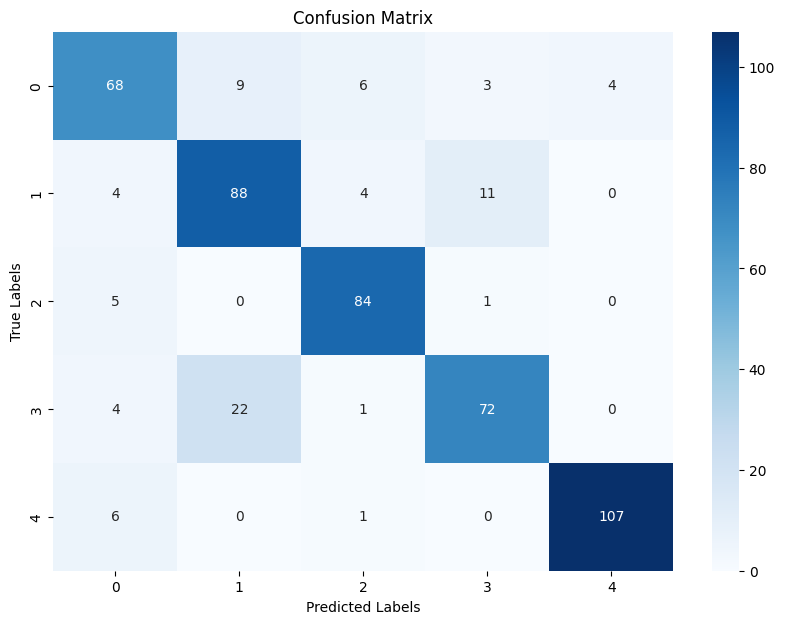

<ipython-input-65-b2ea606d2da8>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.arange(len(misclassifications)), y=misclassifications, palette='Blues')


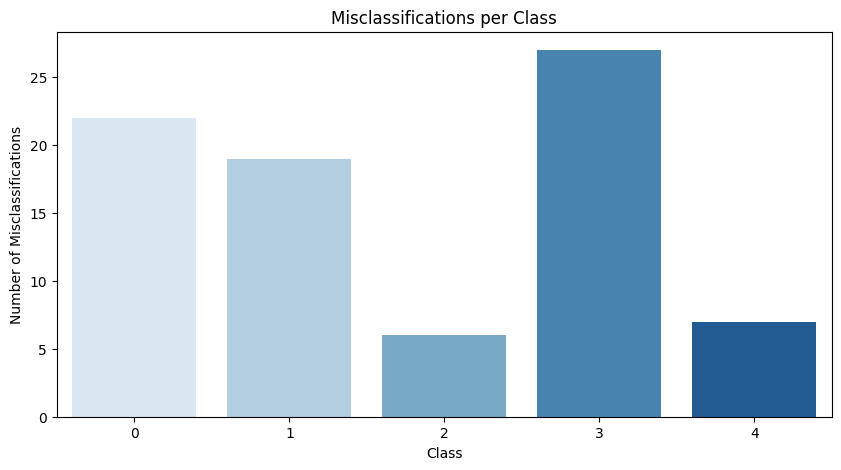

Class with the most misclassifications: 3


In [65]:
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate the number of misclassifications for each class
misclassifications = cm.sum(axis=1) - np.diag(cm)

# Plot bar plot for misclassifications
plt.figure(figsize=(10, 5))
sns.barplot(x=np.arange(len(misclassifications)), y=misclassifications, palette='Blues')
plt.xlabel('Class')
plt.ylabel('Number of Misclassifications')
plt.title('Misclassifications per Class')
plt.show()

# Find the class with the maximum number of misclassifications
max_misclass_idx = np.argmax(misclassifications)
print("Class with the most misclassifications:", max_misclass_idx)

##### Random Forest

In [66]:

def objective(trial):
    # Define hyperparameters search space
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    }

    # Instantiate Random Forest model with suggested hyperparameters
    rf_model = RandomForestClassifier(**param)

    # Fit the model
    rf_model.fit(x_train, y_train)

    # Make predictions on test data
    y_pred = rf_model.predict(x_test)

    # Calculate accuracy on test data
    test_accuracy = accuracy_score(y_test, y_pred)

    # Return accuracy on test data as the objective value
    return test_accuracy

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=300)

# Print the best hyperparameters found
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Instantiate the Random Forest model with the best hyperparameters
best_rf_model = RandomForestClassifier(**best_params)

# Fit the model
best_rf_model.fit(x_train, y_train)

# Make predictions on test data
y_pred = best_rf_model.predict(x_test)

# Evaluate the model
print("\nAccuracy On Test Data:", accuracy_score(y_test, y_pred))


[I 2024-03-31 12:40:53,831] A new study created in memory with name: no-name-9cf08669-5769-4963-9f3a-c119ca01eded
[I 2024-03-31 12:40:55,017] Trial 0 finished with value: 0.806 and parameters: {'n_estimators': 175, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 0 with value: 0.806.
[I 2024-03-31 12:40:57,213] Trial 1 finished with value: 0.8 and parameters: {'n_estimators': 168, 'max_depth': 19, 'min_samples_split': 17, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.806.
[I 2024-03-31 12:40:58,318] Trial 2 finished with value: 0.816 and parameters: {'n_estimators': 189, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 17, 'max_features': 'log2'}. Best is trial 2 with value: 0.816.
[I 2024-03-31 12:40:58,476] Trial 3 finished with value: 0.796 and parameters: {'n_estimators': 13, 'max_depth': 11, 'min_samples_split': 19, 'min_samples_leaf': 11, 'max_features': 'sqrt'}. Best is trial 2 wi

Best Hyperparameters: {'n_estimators': 57, 'max_depth': 11, 'min_samples_split': 9, 'min_samples_leaf': 20, 'max_features': 'log2'}

Accuracy On Test Data: 0.814


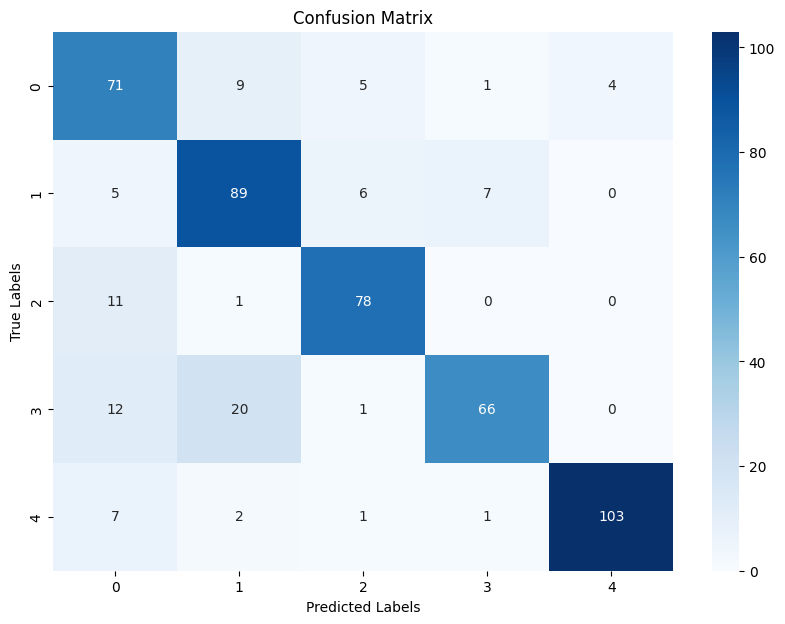

<ipython-input-67-b2ea606d2da8>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.arange(len(misclassifications)), y=misclassifications, palette='Blues')


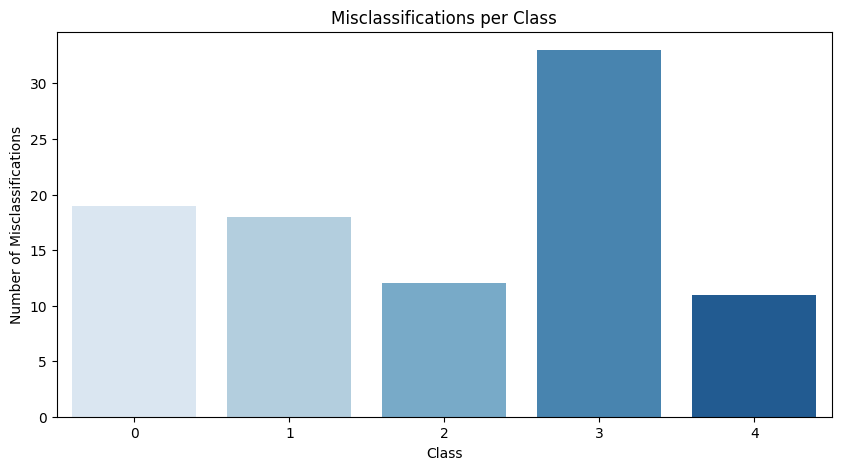

Class with the most misclassifications: 3


In [67]:
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate the number of misclassifications for each class
misclassifications = cm.sum(axis=1) - np.diag(cm)

# Plot bar plot for misclassifications
plt.figure(figsize=(10, 5))
sns.barplot(x=np.arange(len(misclassifications)), y=misclassifications, palette='Blues')
plt.xlabel('Class')
plt.ylabel('Number of Misclassifications')
plt.title('Misclassifications per Class')
plt.show()

# Find the class with the maximum number of misclassifications
max_misclass_idx = np.argmax(misclassifications)
print("Class with the most misclassifications:", max_misclass_idx)

##### SVM

In [68]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import optuna
import numpy as np

# Define the objective function
def objective(trial):
    # Define hyperparameters search space
    param = {
        'C': trial.suggest_float('C', 0.1, 10.0),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf']),
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto'])
    }

    # Instantiate SVM model with suggested hyperparameters
    svm_model = SVC(**param)

    # Fit the model
    svm_model.fit(x_train, y_train)

    # Make predictions on test data
    y_pred = svm_model.predict(x_test)

    # Calculate accuracy on test data
    test_accuracy = accuracy_score(y_test, y_pred)

    # Return accuracy on test data as the objective value
    return test_accuracy

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

# Print the best hyperparameters found
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Instantiate the SVM model with the best hyperparameters
best_svm_model = SVC(**best_params)

# Fit the model
best_svm_model.fit(x_train, y_train)

# Make predictions on test data
y_pred = best_svm_model.predict(x_test)

# Evaluate the model
print("\nAccuracy On Test Data:", accuracy_score(y_test, y_pred))


[I 2024-03-31 12:43:36,057] A new study created in memory with name: no-name-47d25825-38f8-4111-9384-7fc8fbbe1078
[I 2024-03-31 12:43:36,361] Trial 0 finished with value: 0.82 and parameters: {'C': 6.679508904779321, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 0 with value: 0.82.
[I 2024-03-31 12:43:36,489] Trial 1 finished with value: 0.828 and parameters: {'C': 3.088776141951631, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 1 with value: 0.828.
[I 2024-03-31 12:43:36,612] Trial 2 finished with value: 0.83 and parameters: {'C': 2.3737211329151773, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 2 with value: 0.83.
[I 2024-03-31 12:43:36,741] Trial 3 finished with value: 0.826 and parameters: {'C': 0.9133047506155498, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 2 with value: 0.83.
[I 2024-03-31 12:43:36,880] Trial 4 finished with value: 0.818 and parameters: {'C': 8.942428448323328, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 2 with value: 0.83.
[I 2

Best Hyperparameters: {'C': 0.1354606404613936, 'kernel': 'linear', 'gamma': 'auto'}

Accuracy On Test Data: 0.836


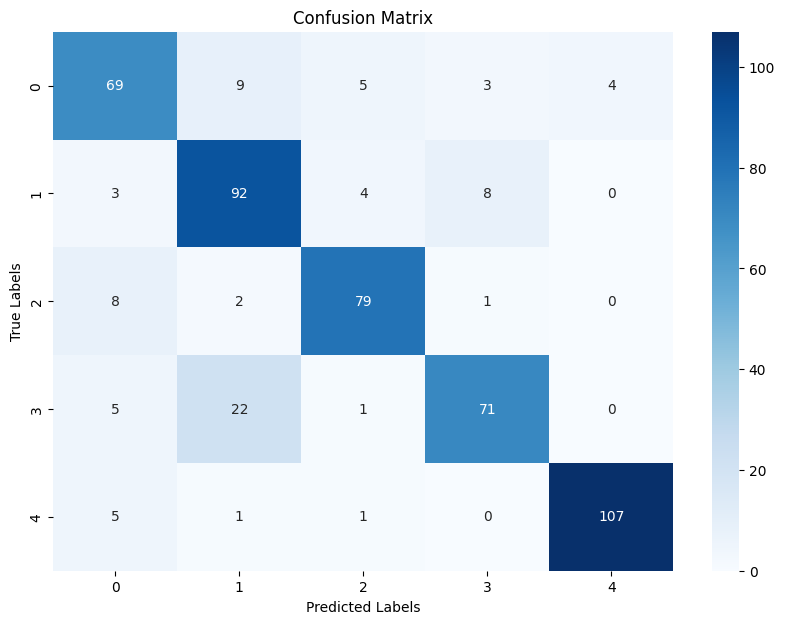

<ipython-input-69-b2ea606d2da8>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.arange(len(misclassifications)), y=misclassifications, palette='Blues')


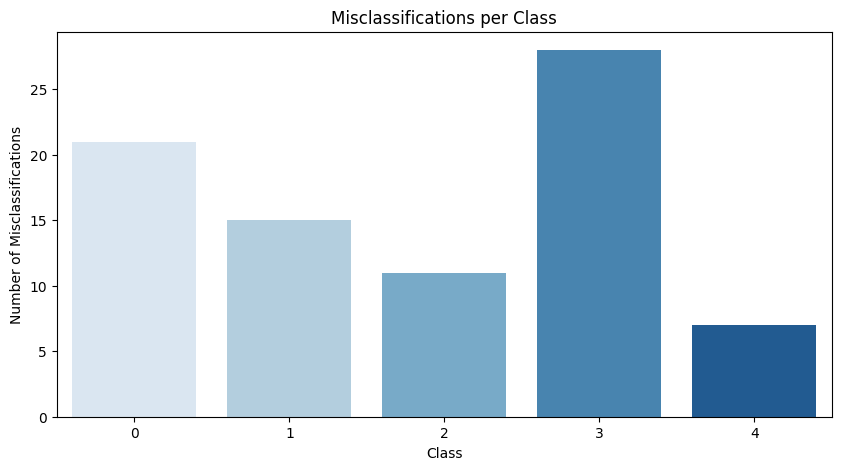

Class with the most misclassifications: 3


In [69]:
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate the number of misclassifications for each class
misclassifications = cm.sum(axis=1) - np.diag(cm)

# Plot bar plot for misclassifications
plt.figure(figsize=(10, 5))
sns.barplot(x=np.arange(len(misclassifications)), y=misclassifications, palette='Blues')
plt.xlabel('Class')
plt.ylabel('Number of Misclassifications')
plt.title('Misclassifications per Class')
plt.show()

# Find the class with the maximum number of misclassifications
max_misclass_idx = np.argmax(misclassifications)
print("Class with the most misclassifications:", max_misclass_idx)

### Deep Learning

##### CNN for Text

In [70]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.initializers import Constant
from keras.models import Model
from keras.layers import *


sequence_length = 500
max_features = 30000

tokenizer = Tokenizer(num_words=max_features, split=' ', oov_token='<unw>')
tokenizer.fit_on_texts(df['paragraph'].values)

# this takes our sentences and replaces each word with an integer
X = tokenizer.texts_to_sequences(df['paragraph'].values)

# we then pad the sequences so they're all the same length (sequence_length)
X = pad_sequences(X, sequence_length)

y = pd.get_dummies(df['label']).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=500, shuffle=False)

print("test set size " + str(len(X_test)))

test set size 500


In [71]:
embedding_dim = 300
num_filters = 100

inputs = Input(shape=(sequence_length,), dtype='int32')

# use a random embedding for the text
embedding_layer = Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=sequence_length)(inputs)
reshape = Reshape((sequence_length, embedding_dim, 1))(embedding_layer)

# the convolution window acts on the whole 300 dimensions
conv_0 = Conv2D(num_filters, kernel_size=(3, embedding_dim), activation='relu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(4, embedding_dim), activation='relu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(5, embedding_dim), activation='relu')(reshape)
# perform max pooling on each of the convoluations
maxpool_0 = MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - 4 + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - 5 + 1, 1), strides=(1,1), padding='valid')(conv_2)

# concat and flatten
concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)

# do dropout and predict
dropout = Dropout(0.5)(flatten)
output = Dense(units=5, activation='softmax')(dropout)

In [72]:
model = Model(inputs=inputs, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 500)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 500, 300)             9000000   ['input_1[0][0]']             
                                                                                                  
 reshape (Reshape)           (None, 500, 300, 1)          0         ['embedding[0][0]']           
                                                                                                  
 conv2d (Conv2D)             (None, 498, 1, 100)          90100     ['reshape[0][0]']             
                                                                                              

In [73]:
batch_size = 32
history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, verbose=1, validation_split=0.2, shuffle=True)

Epoch 1/10
30/30 [==============================] - 54s 2s/step - loss: 1.5084 - accuracy: 0.4905 - val_loss: 1.2513 - val_accuracy: 0.8033
Epoch 2/10
30/30 [==============================] - 50s 2s/step - loss: 0.9450 - accuracy: 0.7626 - val_loss: 0.5981 - val_accuracy: 0.8285
Epoch 3/10
30/30 [==============================] - 48s 2s/step - loss: 0.5767 - accuracy: 0.8078 - val_loss: 0.4771 - val_accuracy: 0.8410
Epoch 4/10
30/30 [==============================] - 48s 2s/step - loss: 0.4135 - accuracy: 0.8624 - val_loss: 0.4694 - val_accuracy: 0.8536
Epoch 5/10
30/30 [==============================] - 47s 2s/step - loss: 0.3534 - accuracy: 0.8750 - val_loss: 0.4639 - val_accuracy: 0.8243
Epoch 6/10
30/30 [==============================] - 49s 2s/step - loss: 0.2688 - accuracy: 0.9076 - val_loss: 0.4847 - val_accuracy: 0.8410
Epoch 7/10
30/30 [==============================] - 48s 2s/step - loss: 0.2070 - accuracy: 0.9422 - val_loss: 0.5222 - val_accuracy: 0.8285
Epoch 8/10
30/30 [==

In [74]:
# Use the model to predict on the test data
predictions = model.predict(X_test)

# `predictions` will contain the probabilities for each class for each sample in X_test
predicted_labels = np.argmax(predictions, axis=1)

# Assuming y_test contains the true labels for the test data
accuracy = accuracy_score(np.argmax(y_test, axis=1), predicted_labels)
print("Accuracy on Test Data:", accuracy)

16/16 [==============================] - 4s 219ms/step
Accuracy on Test Data: 0.794


##### LSTM

In [75]:
lstm_units = 512  # Number of units in the LSTM layer

# Define input layer
inputs = Input(shape=(sequence_length,))

# Embedding layer
embedding_layer = Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=sequence_length)(inputs)

# LSTM layer
lstm_layer = LSTM(units=lstm_units)(embedding_layer)

# Dropout layer for regularization
dropout = Dropout(0.5)(lstm_layer)

# Output layer
output = Dense(units=5, activation='softmax')(dropout)

# Create model
model = Model(inputs=inputs, outputs=output)

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 500, 300)          9000000   
                                                                 
 lstm (LSTM)                 (None, 512)               1665024   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 10667589 (40.69 MB)
Trainable params: 10667589 (40.69 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [76]:
batch_size = 32
history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, verbose=1, validation_split=0.1, shuffle=True)

Epoch 1/10
34/34 [==============================] - 293s 9s/step - loss: 1.5787 - accuracy: 0.3791 - val_loss: 1.4141 - val_accuracy: 0.4917
Epoch 2/10
34/34 [==============================] - 287s 8s/step - loss: 1.1461 - accuracy: 0.6816 - val_loss: 1.7656 - val_accuracy: 0.4167
Epoch 3/10
34/34 [==============================] - 285s 8s/step - loss: 0.7140 - accuracy: 0.7993 - val_loss: 1.1261 - val_accuracy: 0.6167
Epoch 4/10
34/34 [==============================] - 276s 8s/step - loss: 0.4520 - accuracy: 0.8842 - val_loss: 1.1104 - val_accuracy: 0.5833
Epoch 5/10
34/34 [==============================] - 283s 8s/step - loss: 0.2523 - accuracy: 0.9188 - val_loss: 1.2718 - val_accuracy: 0.5833
Epoch 6/10
34/34 [==============================] - 283s 8s/step - loss: 0.2095 - accuracy: 0.9300 - val_loss: 1.2128 - val_accuracy: 0.6083
Epoch 7/10
34/34 [==============================] - 284s 8s/step - loss: 0.2091 - accuracy: 0.9234 - val_loss: 1.1394 - val_accuracy: 0.6000
Epoch 8/10
34

##### Gate Recurrent Unit(GRU)

In [77]:
from keras.layers import GRU

# Define the number of units in the GRU layer
gru_units = 512  # Number of units in the GRU layer
inputs = Input(shape=(sequence_length,))
embedding_dim = 300
embedding_layer = Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=sequence_length)(inputs)
# GRU layer
gru_layer = GRU(units=gru_units)(embedding_layer)

# Dropout layer for regularization
dropout = Dropout(0.5)(gru_layer)

# Output layer
output = Dense(units=5, activation='softmax')(dropout)

# Create model
model = Model(inputs=inputs, outputs=output)

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 500, 300)          9000000   
                                                                 
 gru (GRU)                   (None, 512)               1250304   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 10252869 (39.11 MB)
Trainable params: 10252869 (39.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [78]:
model = Model(inputs=inputs, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
batch_size = 32
history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, verbose=1, validation_split=0.2, shuffle=True)

Epoch 1/10
30/30 [==============================] - 162s 5s/step - loss: 1.6252 - accuracy: 0.3298 - val_loss: 1.4711 - val_accuracy: 0.4142
Epoch 2/10
30/30 [==============================] - 161s 5s/step - loss: 1.3430 - accuracy: 0.6282 - val_loss: 1.3308 - val_accuracy: 0.4895
Epoch 3/10
30/30 [==============================] - 163s 5s/step - loss: 0.8887 - accuracy: 0.7731 - val_loss: 1.0749 - val_accuracy: 0.5900
Epoch 4/10
30/30 [==============================] - 159s 5s/step - loss: 0.4701 - accuracy: 0.8645 - val_loss: 1.0832 - val_accuracy: 0.6192
Epoch 5/10
30/30 [==============================] - 156s 5s/step - loss: 0.2777 - accuracy: 0.9055 - val_loss: 1.2229 - val_accuracy: 0.5941
Epoch 6/10
30/30 [==============================] - 155s 5s/step - loss: 0.2124 - accuracy: 0.9118 - val_loss: 1.2419 - val_accuracy: 0.5983
Epoch 7/10
30/30 [==============================] - 154s 5s/step - loss: 0.1843 - accuracy: 0.9212 - val_loss: 1.2556 - val_accuracy: 0.6276
Epoch 8/10
30

##### Bi-direction LSTM

In [79]:
from keras.layers import LSTM, Bidirectional, Dense, Embedding, Input
from keras.models import Model
# Define the number of units in the GRU layer
embedding_dim = 300
lstm_units = 128

# Define input layer
inputs = Input(shape=(sequence_length,))

# Embedding layer
embedding_layer = Embedding(input_dim=max_features, output_dim=embedding_dim, input_length=sequence_length)(inputs)

# Bidirectional LSTM layer
bi_lstm = Bidirectional(LSTM(units=lstm_units))(embedding_layer)

# Output layer
output = Dense(units=5, activation='softmax')(bi_lstm)

# Create model
model = Model(inputs=inputs, outputs=output)

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 500, 300)          9000000   
                                                                 
 bidirectional (Bidirection  (None, 256)               439296    
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 9440581 (36.01 MB)
Trainable params: 9440581 (36.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [80]:
model = Model(inputs=inputs, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
batch_size = 32
history = model.fit(X_train, y_train, epochs=10, batch_size=batch_size, verbose=1, validation_split=0.2, shuffle=True)

Epoch 1/10
30/30 [==============================] - 80s 3s/step - loss: 1.5261 - accuracy: 0.3487 - val_loss: 1.2794 - val_accuracy: 0.5732
Epoch 2/10
30/30 [==============================] - 75s 3s/step - loss: 1.1885 - accuracy: 0.5662 - val_loss: 1.1383 - val_accuracy: 0.5858
Epoch 3/10
30/30 [==============================] - 74s 2s/step - loss: 0.9091 - accuracy: 0.7279 - val_loss: 0.8210 - val_accuracy: 0.7197
Epoch 4/10
30/30 [==============================] - 76s 3s/step - loss: 0.5953 - accuracy: 0.8162 - val_loss: 0.8127 - val_accuracy: 0.7573
Epoch 5/10
30/30 [==============================] - 77s 3s/step - loss: 0.3603 - accuracy: 0.8918 - val_loss: 0.8097 - val_accuracy: 0.7071
Epoch 6/10
30/30 [==============================] - 76s 3s/step - loss: 0.2667 - accuracy: 0.9191 - val_loss: 0.8340 - val_accuracy: 0.7322
Epoch 7/10
30/30 [==============================] - 74s 2s/step - loss: 0.2210 - accuracy: 0.9286 - val_loss: 0.7735 - val_accuracy: 0.7490
Epoch 8/10
30/30 [==

# Phân tích kết quả

### Dự đoán sai

In [103]:
from sklearn.model_selection import train_test_split

# Số lượng mẫu bạn muốn có trong tập kiểm tra
test_size = 500

# Lấy tập kiểm tra từ 0 đến 500 đầu tiên của dữ liệu
x_test = df['word2vec'][:test_size]
y_test = df['label'][:test_size]

# Lấy tập huấn luyện từ 500 đến cuối cùng của dữ liệu
x_train = df['word2vec'][test_size:]
y_train = df['label'][test_size:]

# Chuyển đổi thành numpy array (nếu cần)
x_train = np.array([np.array(x) for x in x_train])
x_test = np.array([np.array(x) for x in x_test])

# In các kích thước của các tập dữ liệu
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(1191, 300) (500, 300) (1191,) (500,)


In [104]:
y_test

0      4
1      3
2      4
3      0
4      4
      ..
511    4
512    4
513    1
514    1
515    2
Name: label, Length: 500, dtype: int64

In [105]:
y_pred = best_lr_model.predict(x_test)
false_pre = (y_pred != y_test)
false_pre

0      False
1      False
2      False
3      False
4      False
       ...  
511    False
512    False
513     True
514    False
515    False
Name: label, Length: 500, dtype: bool

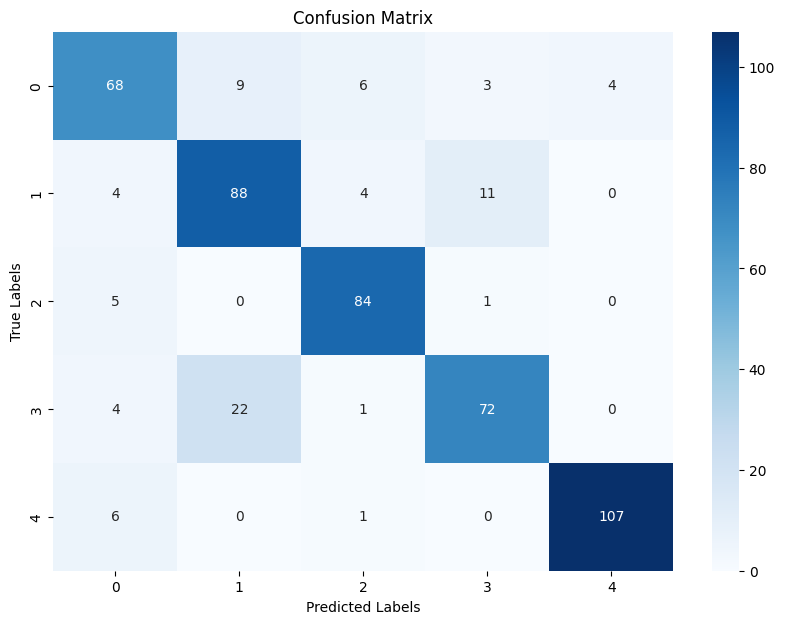

<ipython-input-106-b2ea606d2da8>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.arange(len(misclassifications)), y=misclassifications, palette='Blues')


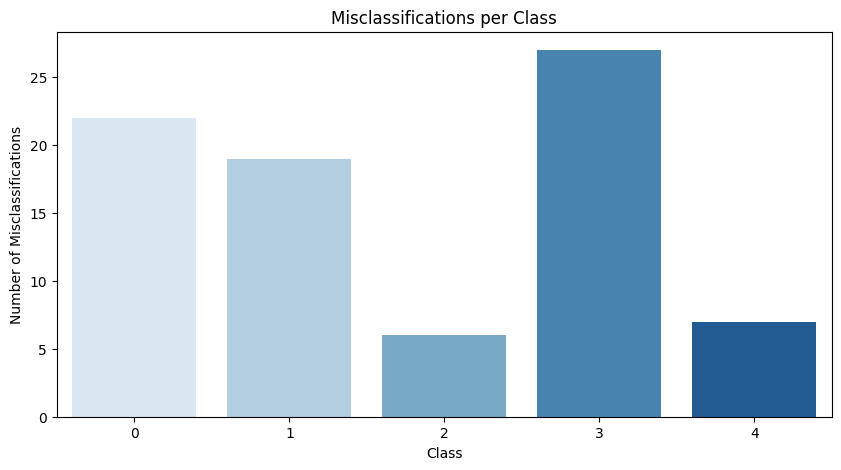

Class with the most misclassifications: 3


In [106]:
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate the number of misclassifications for each class
misclassifications = cm.sum(axis=1) - np.diag(cm)

# Plot bar plot for misclassifications
plt.figure(figsize=(10, 5))
sns.barplot(x=np.arange(len(misclassifications)), y=misclassifications, palette='Blues')
plt.xlabel('Class')
plt.ylabel('Number of Misclassifications')
plt.title('Misclassifications per Class')
plt.show()

# Find the class with the maximum number of misclassifications
max_misclass_idx = np.argmax(misclassifications)
print("Class with the most misclassifications:", max_misclass_idx)

In [107]:
data = {'y_pred': y_pred, 'y_test': y_test}
result_df = pd.DataFrame(data)

# Add false_pre column to the DataFrame
result_df['false_prediction'] = false_pre

# Filter out the rows where false_pre is True
false_predictions = result_df[result_df['false_prediction']]

# Print the DataFrame containing false predictions
print(false_predictions)

     y_pred  y_test  false_prediction
8         3       0              True
16        1       3              True
31        1       0              True
45        0       2              True
61        3       1              True
..      ...     ...               ...
495       2       0              True
497       1       0              True
501       1       3              True
506       3       2              True
513       3       1              True

[81 rows x 3 columns]


In [108]:
# Lọc các giá trị false có class = 3
false_pre_class_3 = (false_pre) & (y_test == 3)

# In ra các dự đoán false với class = 3
print((false_pre_class_3==True).sum())
# Truy xuất các giá trị false với class = 3
# Lọc ra chỉ các giá trị đúng (True) từ mảng boolean false_pre_class_3
true_indices = np.where(false_pre_class_3)

# In ra chỉ các giá trị đúng (True)
df_false_3 = df.iloc[true_indices]


27


In [110]:
import nltk
from collections import Counter

# Tách từng từ trong cột combined_text và tính tần suất xuất hiện của từng từ
all_words = []
for text in df_false_3['combined_text']:
    words = str(text).split()
    all_words.extend(words)

# Tính tần suất xuất hiện của từng từ
word_freq = Counter(all_words)

# In ra phân phối của các từ
print(word_freq)

Counter({"'health',": 178, "'peopl',": 134, "'studi',": 119, "'research',": 117, "'use',": 114, "'hear',": 93, "'year',": 74, "'risk',": 73, "'gun',": 72, "'new',": 71, "'u',": 71, "'also',": 70, "'news',": 70, "'age',": 68, "'patient',": 60, "'like',": 60, "'one',": 59, "'could',": 58, "'protein',": 55, "'state',": 53, "'time',": 50, "'medic',": 50, "'drug',": 49, "'may',": 48, "'death',": 48, "'aid',": 45, "'care',": 43, "'get',": 42, "'woman',": 42, "'clinic',": 41, "'work',": 41, "'diseas',": 40, "'univers',": 40, "'donot',": 40, "'case',": 39, "'mani',": 39, "'violenc',": 39, "'find',": 38, "'report',": 38, "'embryo',": 38, "'imag',": 36, "'know',": 36, "'would',": 35, "'go',": 35, "'nation',": 35, "'make',": 35, "'help',": 35, "'ketamin',": 35, "'includ',": 34, "'call',": 33, "'abort',": 33, "'treatment',": 32, "'issu',": 32, "'test',": 32, "'fall',": 32, "'take',": 31, "'even',": 31, "'found',": 31, "'dog',": 31, "'day',": 31, "'sever',": 30, "'increas',": 30, "'show',": 30, "'c

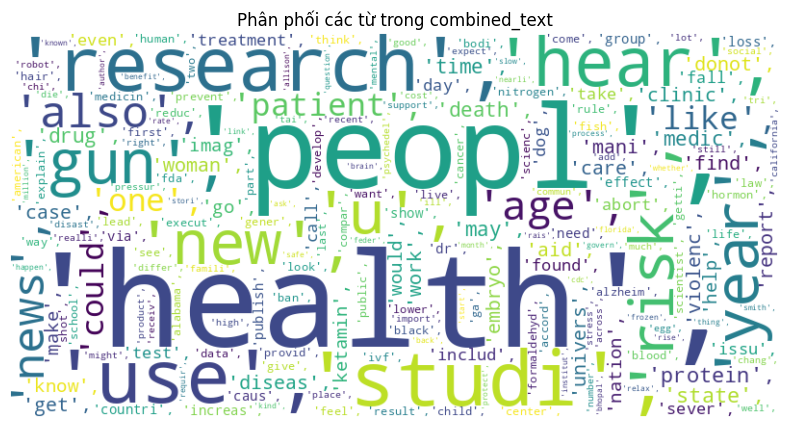

In [111]:
from wordcloud import WordCloud

# Tạo WordCloud object và thiết lập tần suất xuất hiện của từng từ làm dữ liệu đầu vào
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Vẽ biểu đồ WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Phân phối các từ trong combined_text')
plt.show()


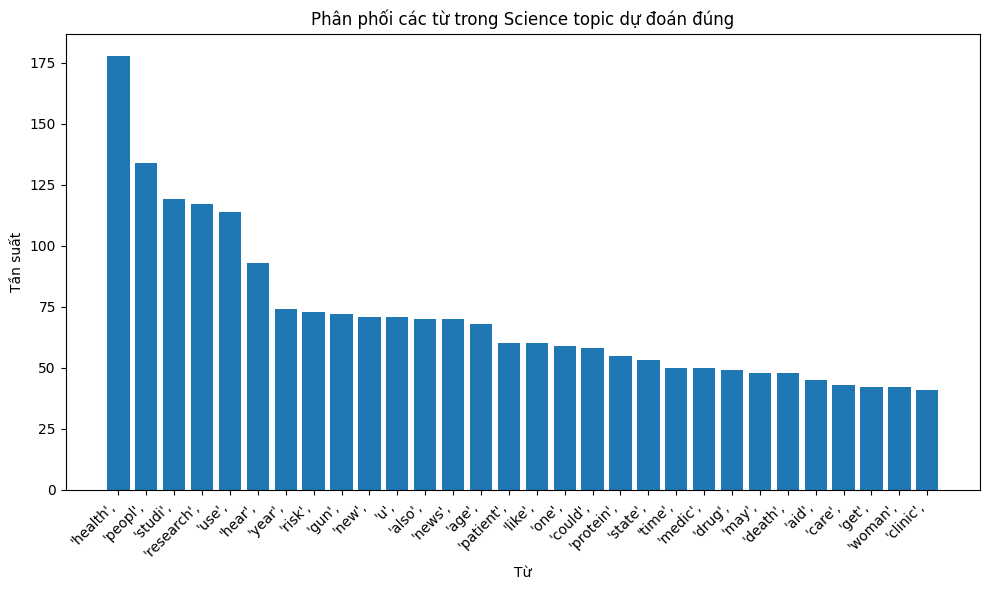

In [112]:


# Chuyển từ điển tần suất thành danh sách tuple và sắp xếp theo tần suất giảm dần
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

# Lấy ra các từ và tần suất tương ứng
words = [item[0] for item in sorted_word_freq]
freqs = [item[1] for item in sorted_word_freq]

# Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))
plt.bar(words[:30], freqs[:30])  # Chỉ hiển thị 20 từ phổ biến nhất
plt.xlabel('Từ')
plt.ylabel('Tần suất')
plt.title('Phân phối các từ trong Science topic dự đoán đúng')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [113]:
# Tạo một DataFrame mới chứa chỉ các dòng thuộc class 1
class_1_df = df[df['label'] == 1]

# Tách từng từ trong cột combined_text của DataFrame mới và tính tần suất xuất hiện của từng từ
all_words_class_1 = []
for text in class_1_df['combined_text']:
    words = str(text).split()
    all_words_class_1.extend(words)

# Tính tần suất xuất hiện của từng từ trong class 1
word_freq_class_1 = Counter(all_words_class_1)

# In ra phân phối của các từ trong class 1
print(word_freq_class_1)


Counter({"'health',": 1698, "'peopl',": 1610, "'like',": 940, "'patient',": 908, "'year',": 863, "'medic',": 817, "'one',": 813, "'use',": 804, "'state',": 803, "'get',": 780, "'new',": 769, "'drug',": 746, "'u',": 716, "'care',": 706, "'also',": 703, "'studi',": 667, "'research',": 655, "'time',": 641, "'case',": 640, "'hospit',": 613, "'would',": 601, "'woman',": 600, "'could',": 581, "'child',": 563, "'make',": 536, "'news',": 532, "'need',": 529, "'go',": 527, "'help',": 518, "'includ',": 500, "'report',": 494, "'work',": 493, "'diseas',": 491, "'mani',": 483, "'cancer',": 479, "'may',": 474, "'vaccin',": 462, "'day',": 452, "'see',": 451, "'npr',": 451, "'death',": 437, "'risk',": 429, "'live',": 428, "'take',": 422, "'first',": 412, "'issu',": 395, "'famili',": 392, "'doctor',": 391, "'call',": 387, "'univers',": 382, "'even',": 381, "'accord',": 380, "'school',": 378, "'food',": 375, "'center',": 371, "'come',": 366, "'test',": 364, "'chang',": 362, "'two',": 357, "'found',": 35

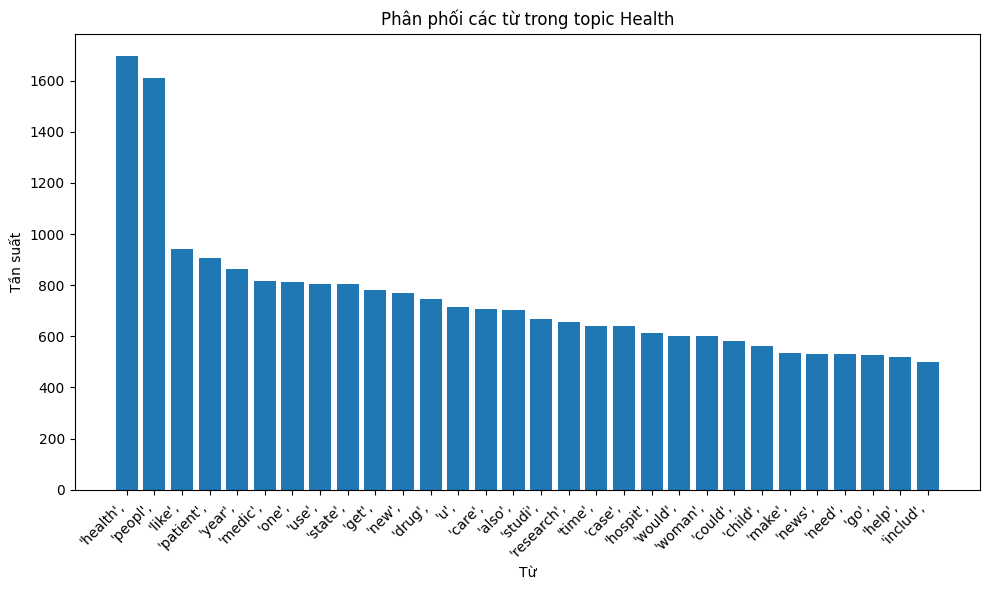

In [114]:

# Chuyển từ điển tần suất thành danh sách tuple và sắp xếp theo tần suất giảm dần
sorted_word_freq_class_1 = sorted(word_freq_class_1.items(), key=lambda x: x[1], reverse=True)

# Lấy ra các từ và tần suất tương ứng
words_class_1 = [item[0] for item in sorted_word_freq_class_1]
freqs_class_1 = [item[1] for item in sorted_word_freq_class_1]

# Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))
plt.bar(words_class_1[:30], freqs_class_1[:30])  # Chỉ hiển thị 20 từ phổ biến nhất
plt.xlabel('Từ')
plt.ylabel('Tần suất')
plt.title('Phân phối các từ trong topic Health')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Trường hợp bị trùng label

In [115]:
df3 = pd.read_csv("data.csv")
df3 = df3.dropna()
df3.shape

(1691, 4)

In [116]:
df3.drop_duplicates(inplace=True)
df3.shape

(1691, 4)

In [117]:
category = df3["category"]
df3.drop("category", axis=1, inplace=True)
df3.drop_duplicates(inplace=True)
df3.shape

(1569, 3)

Vậy model sau khi được loại nhỏ những nhãn trùng sẽ ra sao ?

In [118]:
# Remove "Enlarge this image" from the content column
df3['content'] = df3['content'].str.replace('Enlarge this image', '')
df3['content'] = df3['content'].str.replace('hide caption', '')
df3['content'] = df3['content'].str.replace('toggle caption', '')
df3['content'] = df3['content'].str.replace('caption toggle', '')
# Display the DataFrame with the modified content column
df3

title  \
0     Oscar Pistorius, Paralympian convicted of murd...   
1     Aliens, killer asteroids and Mars: Lawmakers a...   
2     The 2024 Super Bowl becomes the most watched N...   
3     EVs won over early adopters, but mainstream bu...   
4     MLB commissioner Rob Manfred says he will reti...   
...                                                 ...   
1740  California wildfires created toxic chromium, r...   
1741  Iowa's Caitlin Clark becomes all-time NCAA wom...   
1742  They opened a Haitian food truck, then were to...   
1743  Ex-coach sues Northwestern for $130M for wrong...   
1744  Lessons from sleeplessness: The 60th anniversa...   

                                                content  \
0      Paralympian athlete Oscar Pistorius, accused ...   
1     Two lawmakers on Wednesday announced a newly r...   
2      A San Francisco 49ers fan reacts while watchi...   
3      Electric F-150 Lightning pickup trucks travel...   
4     TAMPA, Fla. — Baseball Commissioner Rob Manfre...   
...                                                 ...   
1740  After some recent intense wildfires in Norther...   
1741  Iowa Hawkeyes guard Caitlin Clark has been mak...   
1742  A married couple who fled Haiti for Virginia a...   
1743   Then-Northwestern head coach Pat Fitzgerald s...   
1744   In January 1964, American student Randy Gardn...   

                                                   link  
0     https://www.npr.org/2023/11/24/1215084865/osca...  
1     https://www.nbcnews.com/science/space/lawmaker...  
2     https://www.npr.org/2024/02/13/1231058556/most...  
3     https://www.npr.org/2024/02/07/1227707306/ev-e...  
4     https://www.nbcnews.com/news/sports/mlb-commis...  
...                                                 ...  
1740  https://www.nbcnews.com/science/environment/ca...  
1741  https://www.nbcnews.com/news/sports/caitlin-cl...  
1742  https://www.nbcnews.com/news/nbcblk/haitian-fo...  
1743  https://www.npr.org/2023/10/05/1203949028/nort...  
1744  https://www.npr.org/2024/01/28/1227217274/slee...  

[1569 rows x 3 columns]

In [119]:
df3["category"] = category

In [120]:
df3 = pd.DataFrame(df3)
def remove_url(data):
    url_removed = []
    for line in data:
        url_removed.append(re.sub('http[s]?://\S+', '', line))
    return url_removed
df3 = df3.astype(str)
df3 = df3.apply(remove_url)
def remove_hashtag(data):
    hashtag_removed = []
    translator = str.maketrans('#', ' '*len('#'), '')
    for line in data:
        hashtag_removed.append(line.translate(translator))
    return hashtag_removed

df3 = df3.apply(remove_hashtag)
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df3["title"]= df3["title"].apply(lambda text: remove_punctuation(text))
df3["content"]= df3["content"].apply(lambda text: remove_punctuation(text))
df3["title"] = df3["title"].apply(lambda x: re.sub(r"[–”“—’‘]", "", x))
df3["content"] = df3["content"].apply(lambda x: re.sub(r"[–”“—’‘]", "", x))
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))
contractions_dict = {"ain't": "are not","'s":" is","aren't": "are not", "n't" : "not"}
# Regular expression for finding contractions
# "'d" :"had or would"
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))
def expand_contractions(text,contractions_dict=contractions_dict):
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, text)
# Expanding Contractions in the reviews
df3['content']=df3['content'].apply(lambda x:expand_contractions(x))
df3['title']=df3['title'].apply(lambda x:expand_contractions(x))
df3['title'] = df3['title'].str.lower()
df3['content'] = df3['content'].str.lower()
def tokenize_sentence(data):
  tokenized_docs = []

  for line in data:
    tokenized_docs.append(word_tokenize(line))

  return tokenized_docs

df3 = df3.apply(tokenize_sentence)

In [121]:
from nltk.stem import WordNetLemmatizer
def remove_digits(data):
    digit_removed = []

    for doc in data:
        temp = []
        for word in doc:
            # Check if the word contains only digits
            if not word.isdigit():
                temp.append(word)
        digit_removed.append(temp)

    return digit_removed

df3 = df3.apply(remove_digits)
def remove_stopwords(data):

  stopword_removed = []

  stop_words = set(stopwords.words('english'))
  more_stop = ["say", "said", "says", "u"]
  for word in more_stop:
    stop_words.add(word)

  for doc in data:
    temp = []
    for word in doc:
      if word not in stop_words:
        temp.append(word)

    stopword_removed.append(temp)

  return stopword_removed

df3 = df3.apply(remove_stopwords)
def apply_stemmer(data):
  stemmed_docs = []

  stemmer = PorterStemmer()

  for doc in data:
    stemmed_docs.append([stemmer.stem(plural) for plural in doc])

  return stemmed_docs

df3 = df3.apply(apply_stemmer)
def lemmatize_words(data):
    lemmatized_docs = []
    lemmatizer = WordNetLemmatizer()
    for doc in data:
        lemmatized_docs.append([lemmatizer.lemmatize(word) for word in doc])
    return lemmatized_docs
df3 = df3.apply(lemmatize_words)


In [122]:
combined_paragraphs = []
# create a full paragraph of new
for index, row in df3.iterrows():
    title_text = ' '.join(row['title'])
    content_text = ' '.join(row['content'])
    combined_text = title_text + ' ' + content_text
    combined_paragraphs.append(combined_text)

df3['paragraph'] = combined_paragraphs
df3

title  \
0     [oscar, pistoriu, paralympian, convict, murder...   
1     [alien, killer, asteroid, mar, lawmak, announc...   
2     [super, bowl, becom, watch, nfl, championship,...   
3     [ev, earli, adopt, mainstream, buyer, arent, a...   
4         [mlb, commission, rob, manfr, retir, januari]   
...                                                 ...   
1740  [california, wildfir, creat, toxic, chromium, ...   
1741  [iowa, caitlin, clark, becom, alltim, ncaa, wo...   
1742  [open, haitian, food, truck, told, go, back, c...   
1743  [excoach, sue, northwestern, 130m, wrong, term...   
1744  [lesson, sleepless, 60th, anniversari, randi, ...   

                                                content link  category  \
0     [paralympian, athlet, oscar, pistoriu, accus, ...   []   [sport]   
1     [two, lawmak, wednesday, announc, newli, relau...   []  [scienc]   
2     [san, francisco, 49er, fan, react, watch, tele...   []   [sport]   
3     [electr, f150, lightn, pickup, truck, travel, ...   []    [busi]   
4     [tampa, fla, basebal, commission, rob, manfr, ...   []   [sport]   
...                                                 ...  ...       ...   
1740  [recent, intens, wildfir, northern, california...   []  [scienc]   
1741  [iowa, hawkey, guard, caitlin, clark, make, lo...   []   [sport]   
1742  [marri, coupl, fled, haiti, virginia, achiev, ...   []    [busi]   
1743  [thennorthwestern, head, coach, pat, fitzgeral...   []   [sport]   
1744  [januari, american, student, randi, gardner, s...   []  [scienc]   

                                              paragraph  
0     oscar pistoriu paralympian convict murder rele...  
1     alien killer asteroid mar lawmak announc caucu...  
2     super bowl becom watch nfl championship histor...  
3     ev earli adopt mainstream buyer arent along ri...  
4     mlb commission rob manfr retir januari tampa f...  
...                                                 ...  
1740  california wildfir creat toxic chromium resear...  
1741  iowa caitlin clark becom alltim ncaa woman sco...  
1742  open haitian food truck told go back countri l...  
1743  excoach sue northwestern 130m wrong termin haz...  
1744  lesson sleepless 60th anniversari randi gardne...  

[1569 rows x 5 columns]

In [123]:
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

# Define data
paragraphs = df3['paragraph']
tokenized_paragraphs = [simple_preprocess(paragraph) for paragraph in paragraphs]

# Define parameters for Word2Vec model
vector_size = 300
window = 5
min_count = 5


# Train Word2Vec model with specified parameters
word2vec_model = Word2Vec(sentences=tokenized_paragraphs, vector_size=vector_size, window=window, min_count=min_count, sg=0)

# Function to obtain paragraph embeddings using the trained Word2Vec model
def get_paragraph_embedding(paragraph, model):
    # Tokenize and preprocess the paragraph
    tokens = simple_preprocess(paragraph)

    # Filter out tokens that are not in the vocabulary of the Word2Vec model
    tokens_in_vocab = [token for token in tokens if token in model.wv]

    # If no tokens are in the vocabulary, return None
    if not tokens_in_vocab:
        return None

    # Calculate the average word embedding for the tokens in the paragraph
    paragraph_embedding = np.mean([model.wv[token] for token in tokens_in_vocab], axis=0)
    return paragraph_embedding

# Apply the function to each paragraph in the DataFrame
df3['skip_gram'] = df3['paragraph'].apply(lambda x: get_paragraph_embedding(x, word2vec_model))
print(df3['skip_gram'][0])  # Print embedding for the first paragraph

[-1.72915030e-02  9.83954445e-02  1.13738097e-01  1.78587854e-01
  3.54783051e-02 -2.02490449e-01  9.51042995e-02  5.30933321e-01
 -4.15033251e-02 -9.84143019e-02  2.91413832e-02 -1.44951150e-01
 -1.87354468e-04  1.87494218e-01 -4.78476100e-02 -1.09059334e-01
  5.40341474e-02 -1.39918894e-01  1.58282131e-01  8.06232623e-04
 -2.27979854e-01 -3.81048582e-02  1.04515873e-01  1.03944384e-01
  2.53277361e-01  8.16095024e-02 -2.65734553e-01  1.03649154e-01
 -1.11325435e-01 -3.60883474e-02  5.65188155e-02 -9.48298499e-02
 -5.16432822e-02 -8.27196985e-02 -6.61926121e-02  2.82865744e-02
  1.25335395e-01 -2.38245085e-01 -3.28017138e-02 -4.70096469e-02
 -1.39051169e-01 -2.32373155e-03 -9.44908410e-02 -1.01739809e-01
 -3.60834152e-02  1.14007644e-01  2.59771235e-02  1.20445445e-01
 -5.80579303e-02  2.07796186e-01  9.33003277e-02  7.54057616e-02
 -1.47261694e-01 -2.78310589e-02 -6.04535006e-02  1.05986148e-01
  7.93044865e-02 -9.51298419e-03  4.21592556e-02  4.30754088e-02
 -5.88417836e-02 -1.25020

In [125]:
df3['category'] = df3['category'].apply(lambda x: x[0])
label_encoder = LabelEncoder()

df3['label'] = label_encoder.fit_transform(df3['category'])

df3.label.value_counts()

4    332
0    322
3    317
2    300
1    298
Name: label, dtype: int64

In [126]:
from sklearn.model_selection import train_test_split

# Số lượng mẫu bạn muốn có trong tập kiểm tra
test_size = 500

# Lấy tập kiểm tra từ 0 đến 500 đầu tiên của dữ liệu
x_test = df3['skip_gram'][:test_size]
y_test = df3['label'][:test_size]

# Lấy tập huấn luyện từ 500 đến cuối cùng của dữ liệu
x_train = df3['skip_gram'][test_size:]
y_train = df3['label'][test_size:]

# Chuyển đổi thành numpy array (nếu cần)
x_train = np.array([np.array(x) for x in x_train])
x_test = np.array([np.array(x) for x in x_test])

# In các kích thước của các tập dữ liệu
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(1069, 300) (500, 300) (1069,) (500,)


In [127]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import optuna
import numpy as np

# Define the objective function
def objective(trial):
    # Define hyperparameters search space
    param = {
        'C': trial.suggest_float('C', 0.1, 10.0),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf']),
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto'])
    }

    # Instantiate SVM model with suggested hyperparameters
    svm_model = SVC(**param)

    # Fit the model
    svm_model.fit(x_train, y_train)

    # Make predictions on test data
    y_pred = svm_model.predict(x_test)

    # Calculate accuracy on test data
    test_accuracy = accuracy_score(y_test, y_pred)

    # Return accuracy on test data as the objective value
    return test_accuracy

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

# Print the best hyperparameters found
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Instantiate the SVM model with the best hyperparameters
best_svm_model = SVC(**best_params)

# Fit the model
best_svm_model.fit(x_train, y_train)

# Make predictions on test data
y_pred = best_svm_model.predict(x_test)

# Evaluate the model
print("\nAccuracy On Test Data:", accuracy_score(y_test, y_pred))


[I 2024-03-31 14:40:31,235] A new study created in memory with name: no-name-bc1603d1-71ee-441b-b9d9-b56d7740425f
[I 2024-03-31 14:40:31,375] Trial 0 finished with value: 0.846 and parameters: {'C': 8.50208107923316, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 0 with value: 0.846.
[I 2024-03-31 14:40:31,458] Trial 1 finished with value: 0.836 and parameters: {'C': 4.792957505232948, 'kernel': 'linear', 'gamma': 'auto'}. Best is trial 0 with value: 0.846.
[I 2024-03-31 14:40:31,549] Trial 2 finished with value: 0.83 and parameters: {'C': 7.373475079587342, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 0 with value: 0.846.
[I 2024-03-31 14:40:31,970] Trial 3 finished with value: 0.51 and parameters: {'C': 0.5154769163833651, 'kernel': 'rbf', 'gamma': 'auto'}. Best is trial 0 with value: 0.846.
[I 2024-03-31 14:40:32,069] Trial 4 finished with value: 0.848 and parameters: {'C': 2.0271276003455507, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 4 with value: 0.848.
[I 20

Best Hyperparameters: {'C': 5.866068445726005, 'kernel': 'rbf', 'gamma': 'scale'}

Accuracy On Test Data: 0.85


In [128]:
# Instantiate SVM model with specified hyperparameters
best_svm_model = SVC(C=0.4, kernel='linear', gamma='scale')

# Fit the model to the training data
best_svm_model.fit(x_train, y_train)

# Make predictions on test data
y_pred = best_svm_model.predict(x_test)

# Calculate accuracy on test data
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Test Data:", accuracy)

Accuracy on Test Data: 0.842


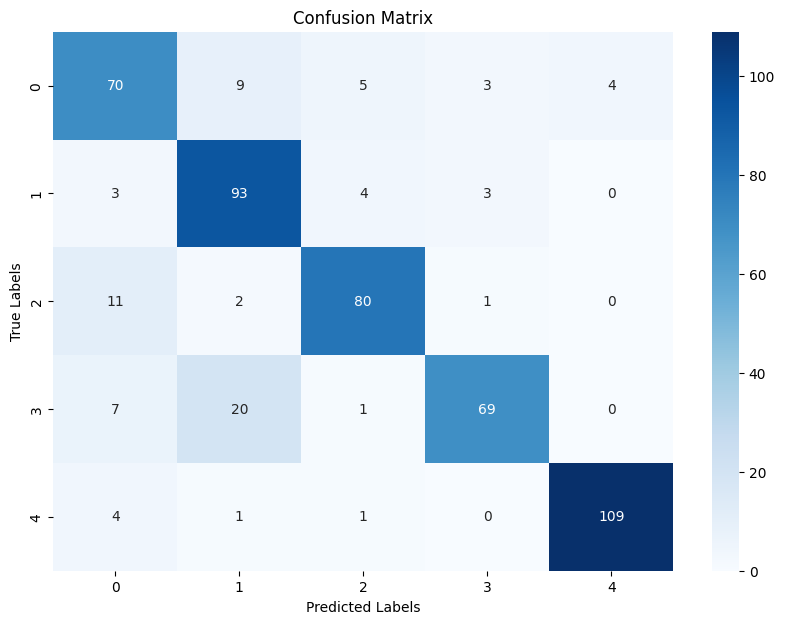

<ipython-input-129-b2ea606d2da8>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.arange(len(misclassifications)), y=misclassifications, palette='Blues')


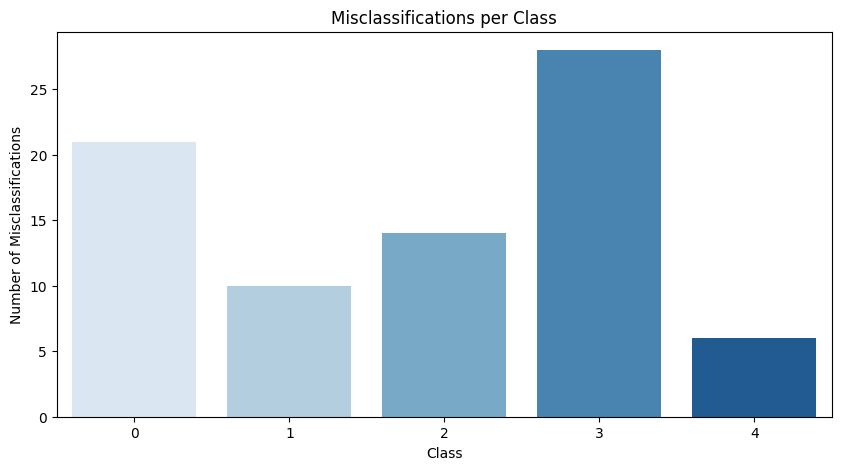

Class with the most misclassifications: 3


In [129]:
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate the number of misclassifications for each class
misclassifications = cm.sum(axis=1) - np.diag(cm)

# Plot bar plot for misclassifications
plt.figure(figsize=(10, 5))
sns.barplot(x=np.arange(len(misclassifications)), y=misclassifications, palette='Blues')
plt.xlabel('Class')
plt.ylabel('Number of Misclassifications')
plt.title('Misclassifications per Class')
plt.show()

# Find the class with the maximum number of misclassifications
max_misclass_idx = np.argmax(misclassifications)
print("Class with the most misclassifications:", max_misclass_idx)

# Reference

https://aclanthology.org/I17-2006.pdf

https://arxiv.org/pdf/2309.13761.pdf

https://arxiv.org/pdf/1703.03130v1.pdf

https://arxiv.org/pdf/2309.13761.pdf

https://arxiv.org/pdf/2004.03705.pdf